<a href="https://www.kaggle.com/code/catalystcooperative/01-pudl-data-access?scriptVersionId=252493079" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Purpose of this Notebook

Provide an introduction to working with the data integrated into Catalyst Cooperative's Public Utility Data Liberation (PUDL) database, from various public data sources. We will use PUDL to explore Companche 3's brief and checkered existence, in terms of its carbon emissions, electricity generation, costs, and reliability.

By the end of this notebook, you will be able to:
- use PUDL to access FERC, EIA, and EPA data about a specific power plant
- use that data, as well as the [PUDL data dictionary](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html) to build a coherent narrative

# Comanche 3: A Snapshot of US Energy Transition

## Background
- In 2009 Xcel Energy Colorado (also known as Public Service Company of Colorado or PSCo) spent about 1.3 billion dollars building one of the last US coal plants in Pueblo, Colorado.
- The plant was bitterly contested from the beginning, with clean energy activists decrying the 60 years of future GHG emissions that the plant was to lock in, and declining economically accessible coal reserves in the Powder River Basin of Wyoming.
- After a decade of [high operating costs, ongoing maintenance issues](https://coloradosun.com/2021/03/03/comanche-3-cost-overruns-shutdown-electricity/), political pressure, and rapid renewable price declines, Xcel finally [agreed to shut the plant down 40 years early](https://coloradosun.com/2022/04/26/comanche-plant-xcel-coal/)


## Datasets we will use
- [FERC Form 1](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/ferc1.html) (the Annual Report of Major Electric Utilities) will provide non-fuel operating costs as well as ongoing capital expenses.
- [EIA Form 860](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/eia860.html) (the Annual Electric Generator Report) will provide detailed physical attributes of individual generators, as well as their ownership shares.
- [EIA Form 923](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/eia923.html) (the Power Plant Operations Report) will provide information about fuel consumption and costs, net electricity generation, and generator thermal efficiency.
- [EPA's Continuous Emissions Monitoring System](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/epacems.html) will provide hourly power plant emissions, fuel consumption, and power output.


## Attributes we will dig into

- cost increases & downtime (plant level)
- monthly net generation/fuel cost/heat rate/capacity factor (generator level)
- hourly power output, fuel consumption, heat rates, emissions intensity (unit level)



# Additional PUDL Project Resources
Links to more information on Catalyst Cooperative's Public Utility Data Liberation (PUDL) Project.

## PUDL Data Dictionaries:
* [Table and column level metadata for the PUDL database](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html)
* [Table level metadata for 2020 and earlier raw FERC Form 1 DBF data](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/ferc1_db.html) (**Note:** the raw FERC Form 1 data is very difficult to work with. Check whether the table you want to work with has been cleaned up and imported into PUDL)
* All XBRL-derived FERC forms (2021 and later) have extensive metadata published alongside their databases in the nightly builds (see below). These take the form of a JSON version of their XBRL taxonomy, and a [datapackage descriptor](https://specs.frictionlessdata.io/data-package/) that annotates the XBRL-derived SQLite DB.

## Nightly Build Outputs:
We attempt to rebuild all of our data products each night, based on the code in [the development branch](https://github.com/catalyst-cooperative/pudl/tree/dev) of the [main PUDL repository on GitHub](https://github.com/catalyst-cooperative/pudl). 

The most recent successful build outputs can be downloaded directly from:
* [The PUDL Project in the AWS Open Data Registry](https://registry.opendata.aws/catalyst-cooperative-pudl/)
* [Direct AWS S3 download links](https://catalystcoop-pudl.readthedocs.io/en/latest/data_access.html#access-nightly-builds) on our data access page.
* The [PUDL Project Dataset](https://www.kaggle.com/datasets/catalystcooperative/pudl-project) on Kaggle updates automatically whenever the nightly builds succeed.

## PUDL Data Viewer: https://viewer.catalyst.coop
Provides a simple web interface for browsing and querying the PUDL database.

## GitHub Discussions
We use [GitHub Discussions](https://github.com/orgs/catalyst-cooperative/discussions) to answer questions about PUDL and provide user support. Let us know if you have issues or find bugs!

# Notebook Setup
Boilerplate setup. You don't have to think hard about this, but if you want to, the comments provide some useful context.

In [1]:
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

print(f"Python version: {sys.version}")
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

print(f"{np.__version__=}")
print(f"{pd.__version__=}")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in sorted(filenames):
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
sns.set()
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16, 10)
matplotlib.rcParams["figure.dpi"] = 150
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 1000)

Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
np.__version__='1.26.4'
pd.__version__='2.2.3'
/kaggle/input/pudl-project/censusdp1tract.sqlite
/kaggle/input/pudl-project/ferc1_dbf.sqlite
/kaggle/input/pudl-project/ferc1_xbrl.sqlite
/kaggle/input/pudl-project/ferc1_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc1_xbrl_taxonomy_metadata.json
/kaggle/input/pudl-project/ferc2_dbf.sqlite
/kaggle/input/pudl-project/ferc2_xbrl.sqlite
/kaggle/input/pudl-project/ferc2_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc2_xbrl_taxonomy_metadata.json
/kaggle/input/pudl-project/ferc60_dbf.sqlite
/kaggle/input/pudl-project/ferc60_xbrl.sqlite
/kaggle/input/pudl-project/ferc60_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc60_xbrl_taxonomy_metadata.json
/kaggle/input/pudl-project/ferc6_dbf.sqlite
/kaggle/input/pudl-project/ferc6_xbrl.sqlite
/kaggle/input/pudl-project/ferc6_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc6_xbrl_taxonomy_metadata.json
/kaggle/input

# Reading data from the PUDL Parquet outputs
- We distribute all of our data as [Apache Parquet](https://parquet.apache.org/) files.
- [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_parquet.html), [DuckDB](https://duckdb.org/docs/stable/data/parquet/overview), [Polars](https://docs.pola.rs/api/python/stable/reference/api/polars.read_parquet.html) and many other libraries have built-in support for reading data from Parquet.
- The data is organized for high performance analytical queries, and compressed on disk. Parquet files can also be queried efficiently remotely.

## Define the path to PUDL Parquet files.
- If this notebook is being run on Kaggle, use the local workspace.
- If it's being run elsewhere, read the PUDL data from the [PUDL AWS Open Data Registry](https://registry.opendata.aws/catalyst-cooperative-pudl/) S3 bucket.

In [2]:
if os.getenv("KAGGLE_URL_BASE", False):
    PARQUET_PATH = "/kaggle/input/pudl-project/pudl_parquet"
else:
    PARQUET_PATH = "s3://pudl.catalyst.coop/nightly"

def read_parquet(table_name: str) -> pd.DataFrame:
    """A helper function to read PUDL Parquet files."""
    return pd.read_parquet(
        f"{PARQUET_PATH}/{table_name}.parquet",
        dtype_backend="pyarrow"
    )

## Read EIA plant data from the PUDL SQLite Database
- We'll read the entire [denormalized annual EIA plants table](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html#out-eia-yearly-plants) -- "denormalized" just means that it has additional useful information merged in that might be duplicative, but is more convenient for interactive use.
- Power plants are industrial facilities operated by a single utility, but they can have multiple owners, and host multiple generation units.
- The `out_eia__yearly_plants` table contains only information that pertains to all of the equipment at the plant. like its location, or connections to the natural gas and electricity transmission systems.
- Most of these attributes are relatively stable, but they can change slowly over time, so each plant has one record for each `report_date`.
- There are also several ID columns in this table that will be useful for joining it with other data later.
- The table has more than 50 columns. You can look up short descriptions of what all these columns mean in the [PUDL Data Dictionary](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html)

In [3]:
%%time
plants_eia = read_parquet("out_eia__yearly_plants")

# Filter to plants with "comanche" in the name, so we can find the PUDL plant ID
plants_eia.loc[
    plants_eia.plant_name_eia.str.contains("comanche", case=False),
    [
        "plant_id_eia",
        "plant_id_pudl",
        "plant_name_eia",
        "utility_name_eia",
        "city",
        "state",
        "latitude",
        "longitude",
    ]
].drop_duplicates()

CPU times: user 574 ms, sys: 189 ms, total: 764 ms
Wall time: 541 ms


plant_id_eia  plant_id_pudl  plant_name_eia  \
51490          59656           8375  Comanche Solar   
51497          59656           8375  Comanche Solar   
150943          8059            127        Comanche   
167879          6145           2514   Comanche Peak   
167894          6145           2514   Comanche Peak   
214176           470            126        Comanche   

                       utility_name_eia       city state   latitude  \
51490                    Novatus Energy     Pueblo    CO  38.205276   
51497                      Comanche LLC     Pueblo    CO  38.205276   
150943    Public Service Co of Oklahoma     Lawton    OK  34.543098   
167879  Luminant Generation Company LLC  Glen Rose    TX  32.298367   
167894             TXU Generation Co LP  Glen Rose    TX  32.298367   
214176    Public Service Co of Colorado     Pueblo    CO  38.208099   

         longitude  
51490  -104.566704  
51497  -104.566704  
150943  -98.324402  
167879  -97.785522  
167894  -97.785522  
214176 -104.574699

## Reading FERC plant data from the PUDL SQLite DB
* The Federal Energy Regulatory Commission (FERC) also reports data about power plants in their [Form 1 - Annual Report of Major Electric Utilities](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/ferc1.html).
* FERC Form 1 focuses primarily on electric utility finances, rather than operations.
* The [Large Steam Plants](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html#out-ferc1-yearly-steam-plants-sched402) table provides particularly detailed capital expenses and non-fuel O&M costs.
* Unfortunately, these detailed costs are often not attributed to individual generators.
* In the case of Comanche, the costs and other data for all 3 units are lumped together at the plant level, obscuring the impact of Comanche 3.

In [4]:
%%time
plants_ferc1 = read_parquet("out_ferc1__yearly_steam_plants_sched402")
plants_ferc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34111 entries, 0 to 34110
Data columns (total 55 columns):
 #   Column                                  Non-Null Count  Dtype                                                       
---  ------                                  --------------  -----                                                       
 0   report_year                             34111 non-null  int32[pyarrow]                                              
 1   utility_id_ferc1                        34111 non-null  int32[pyarrow]                                              
 2   utility_id_pudl                         34111 non-null  int32[pyarrow]                                              
 3   utility_name_ferc1                      34111 non-null  string[pyarrow]                                             
 4   plant_id_pudl                           34111 non-null  int32[pyarrow]                                              
 5   plant_id_ferc1                  

In [5]:
comanche_ferc1 = (
    plants_ferc1.loc[
        plants_ferc1["plant_id_pudl"] == 126,
        [
            "report_year",
            "plant_id_ferc1",
            "plant_name_ferc1",
            "plant_id_pudl",
            "capacity_mw",
            "net_generation_mwh",
            "capacity_factor",
            "capex_annual_addition",  # Total new capital additions for the year. Does not account for retirements / depreciation.
            "capex_annual_per_mw",    # Annual additions divided by plant capacity.
            "capex_annual_per_mwh",   # Annual additions divided by net generation for the year.
            "opex_total_nonfuel",     # Total non-fuel operating expensees. (EIA provides better fuel costs)
            "opex_per_mwh",           # Total operating expenses (including fuel) per MWh of net generation.
            "opex_nonfuel_per_mwh",   # Total non-fuel operating expenses per MWh of net generation.
            "opex_fuel_per_mwh",      # Total fuel-based operating expenses per MWh of net generation.
        ]
    ]
    .assign(report_date=lambda x: pd.to_datetime(x.report_year.astype("string")))
)
comanche_ferc1

report_year  plant_id_ferc1 plant_name_ferc1  plant_id_pudl  \
17117         1994            3037         comanche            126   
17118         1995            3037         comanche            126   
17119         1996            3037         comanche            126   
17120         1997            3037         comanche            126   
17121         1998            3037         comanche            126   
17122         1999            3037         comanche            126   
17123         2000            3037         comanche            126   
17124         2001            3037         comanche            126   
17125         2002            3037         comanche            126   
17126         2003            3037         comanche            126   
17127         2004            3037         comanche            126   
17128         2005            3037         comanche            126   
17129         2006            3037         comanche            126   
17130         2007            3037         comanche            126   
17131         2008            3037         comanche            126   
17132         2009            3037         comanche            126   
17133         2010            3037         comanche            126   
17134         2011            3037         comanche            126   
17135         2012            3037         comanche            126   
17136         2013            3037         comanche            126   
17137         2014            3037         comanche            126   
17138         2015            3037         comanche            126   
17139         2016            3037         comanche            126   
17140         2017            3037         comanche            126   
17141         2018            3037         comanche            126   
17142         2019            3037         comanche            126   
17143         2021            3037         comanche            126   
17144         2022            3037         comanche            126   
17145         2023            3037         comanche            126   
17146         2024            3037         comanche            126   
17220         2020            4404         comanche            126   

       capacity_mw  net_generation_mwh  capacity_factor  \
17117        700.0           3253066.0         0.530507   
17118        700.0           4023033.0         0.656072   
17119        700.0           4319083.0         0.704351   
17120        700.0           4424635.0         0.721565   
17121        700.0           4437115.0           0.7236   
17122        700.0           4563838.0         0.744266   
17123        700.0           4223848.0         0.688821   
17124        700.0           4431900.0          0.72275   
17125        700.0           4697172.0          0.76601   
17126        700.0           4864064.0         0.793226   
17127        700.0           4301827.0         0.701537   
17128        700.0           4292543.0         0.700023   
17129        700.0           4877932.0         0.795488   
17130        700.0           4450973.0          0.72586   
17131        700.0           4378101.0         0.713976   
17132        778.5           4705019.0          0.68992   
17133       1284.0           5959070.0         0.529797   
17134  1635.300049           6169782.0         0.430693   
17135  1635.300049           7421325.0          0.51806   
17136  1635.300049           7239127.0         0.505341   
17137  1635.300049           6859537.0         0.478843   
17138  1635.300049           7029257.0         0.490691   
17139  1635.300049           7182730.0         0.501404   
17140  1635.300049           7577019.0         0.528928   
17141  1635.300049           7860923.0         0.548747   
17142  1635.300049           6658643.0         0.464819   
17143  1635.300049           6466549.0          0.45141   
17144  1635.300049           4579218.5         0.319661   
17145  1252.800049           4818090.0         0.439025

## Cost Increases and Downtime
- Some of the data available from FERC overlaps with the EIA and EPA data (see below). This lets us sanity check the various data sources against each other.
- Both FERC and EIA collect fuel cost and generation data, albeit at different resolutions. FERC Form 1 is reported annually, and typically not at the most granular level of individual generators.
- However, FERC is unique in reporting detailed categories of non-fuel O&M costs and plant capital additions, which are required to build a bottom-up picture of plant production costs.
- In the plots below we look at Comanche's overall plant capacity factor, fuel & non-fuel O&M costs, and the history of capital additions.

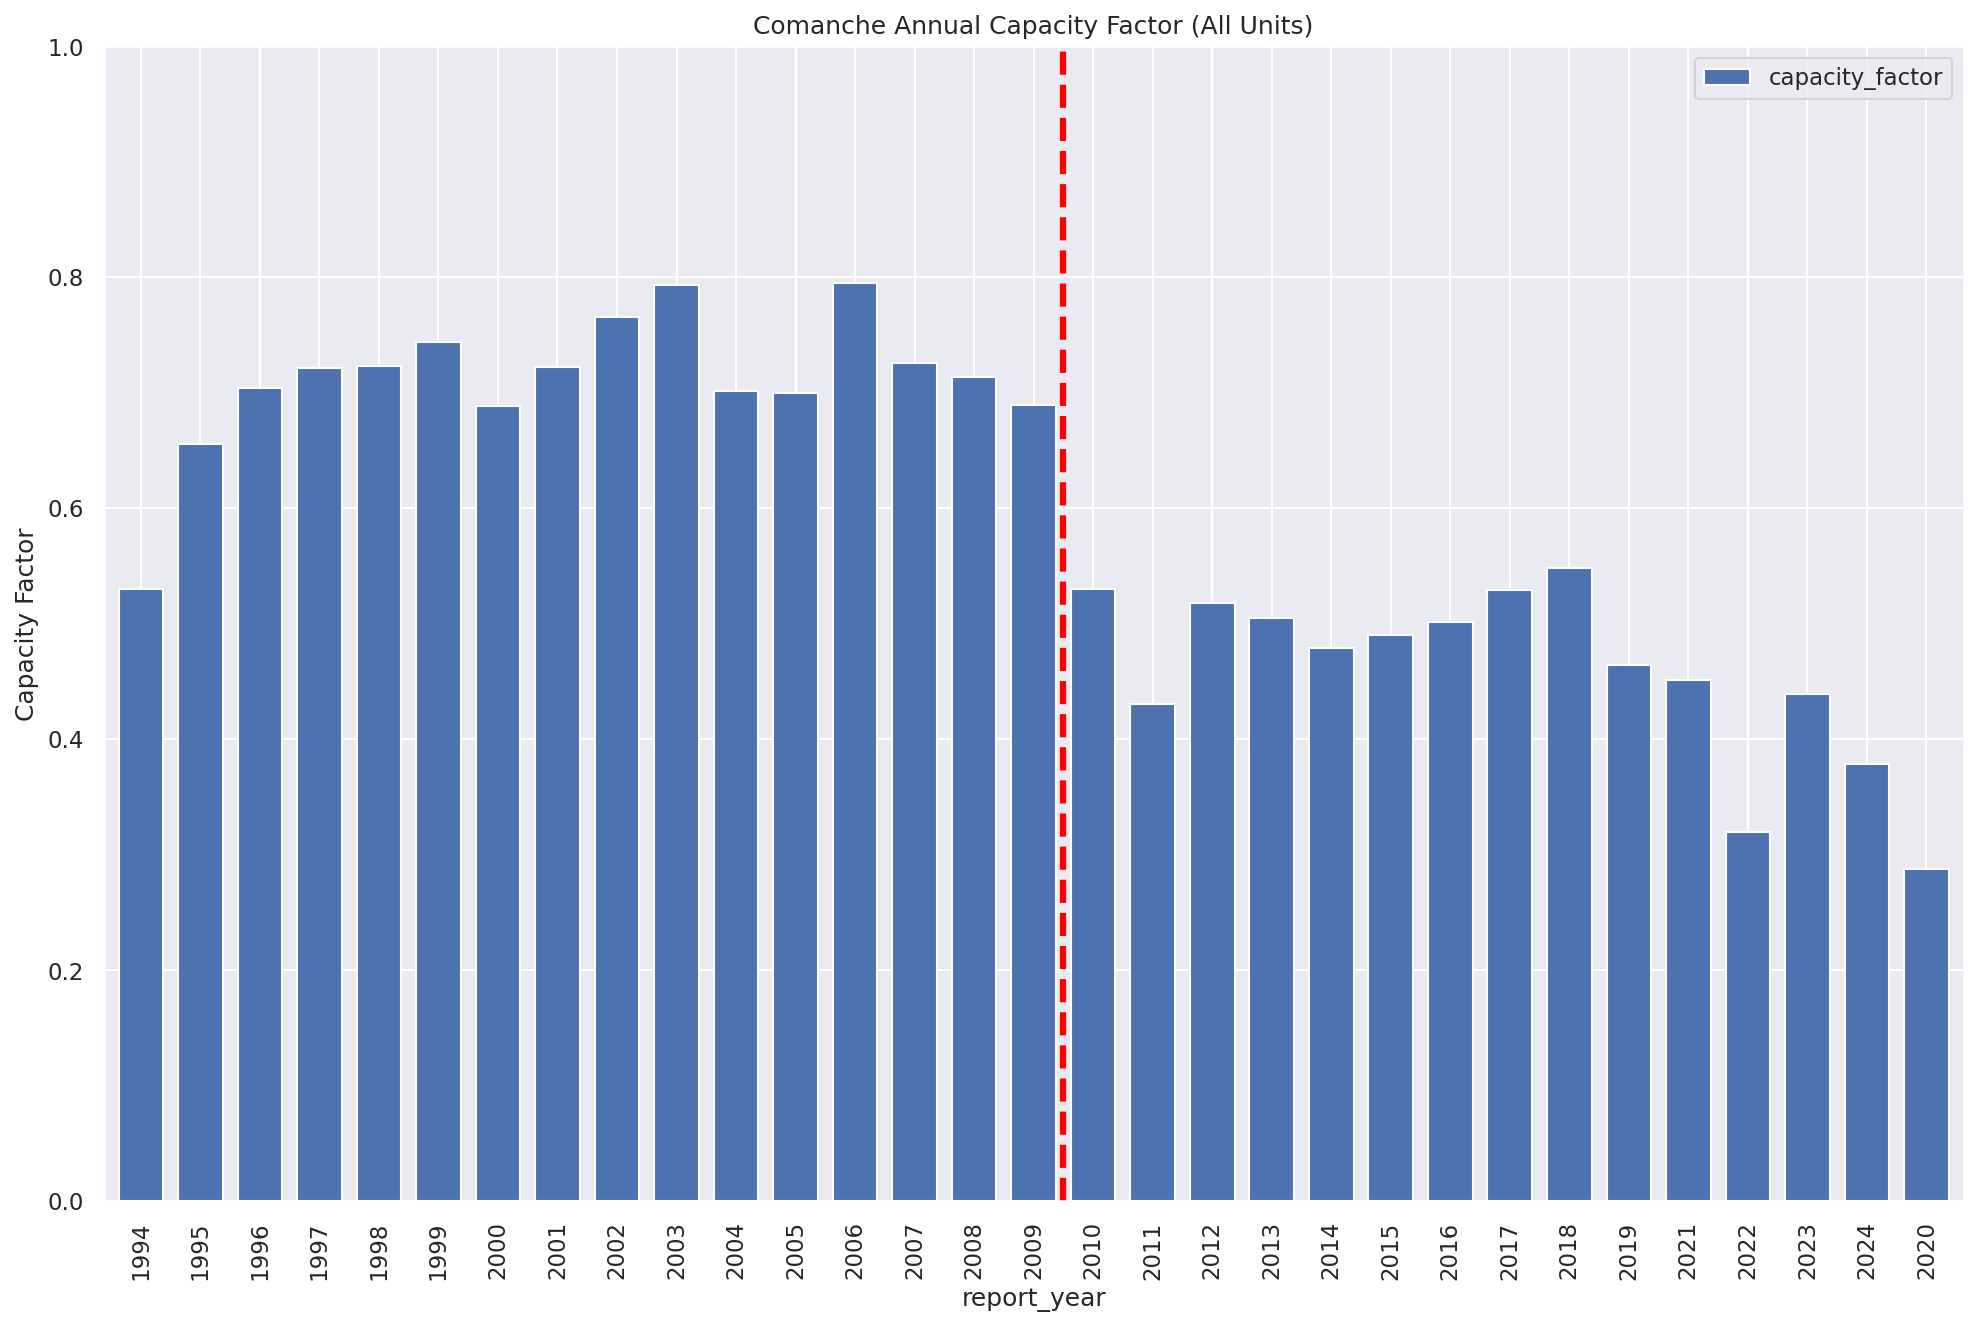

In [6]:
axes = comanche_ferc1.set_index("report_year")[[
    "capacity_factor",
]].plot(
    kind="bar",
    width=0.75,
)
axes.axvline(x=15.5, color="red", linestyle="--", lw=3)
axes.set_ylabel("Capacity Factor")
axes.set_title("Comanche Annual Capacity Factor (All Units)")
axes.set_ylim(0, 1);

- The red dashed line indicates when Unit 3 came online.
- Capacity Factor is the ratio of its actual generation to maximum possible generation if it ran at 100% capacity continuously.
- Overall plant capacity factor dropped sharply with the addition of the large new unit, from a historical level of ~70% to 50% even lower in recent years.

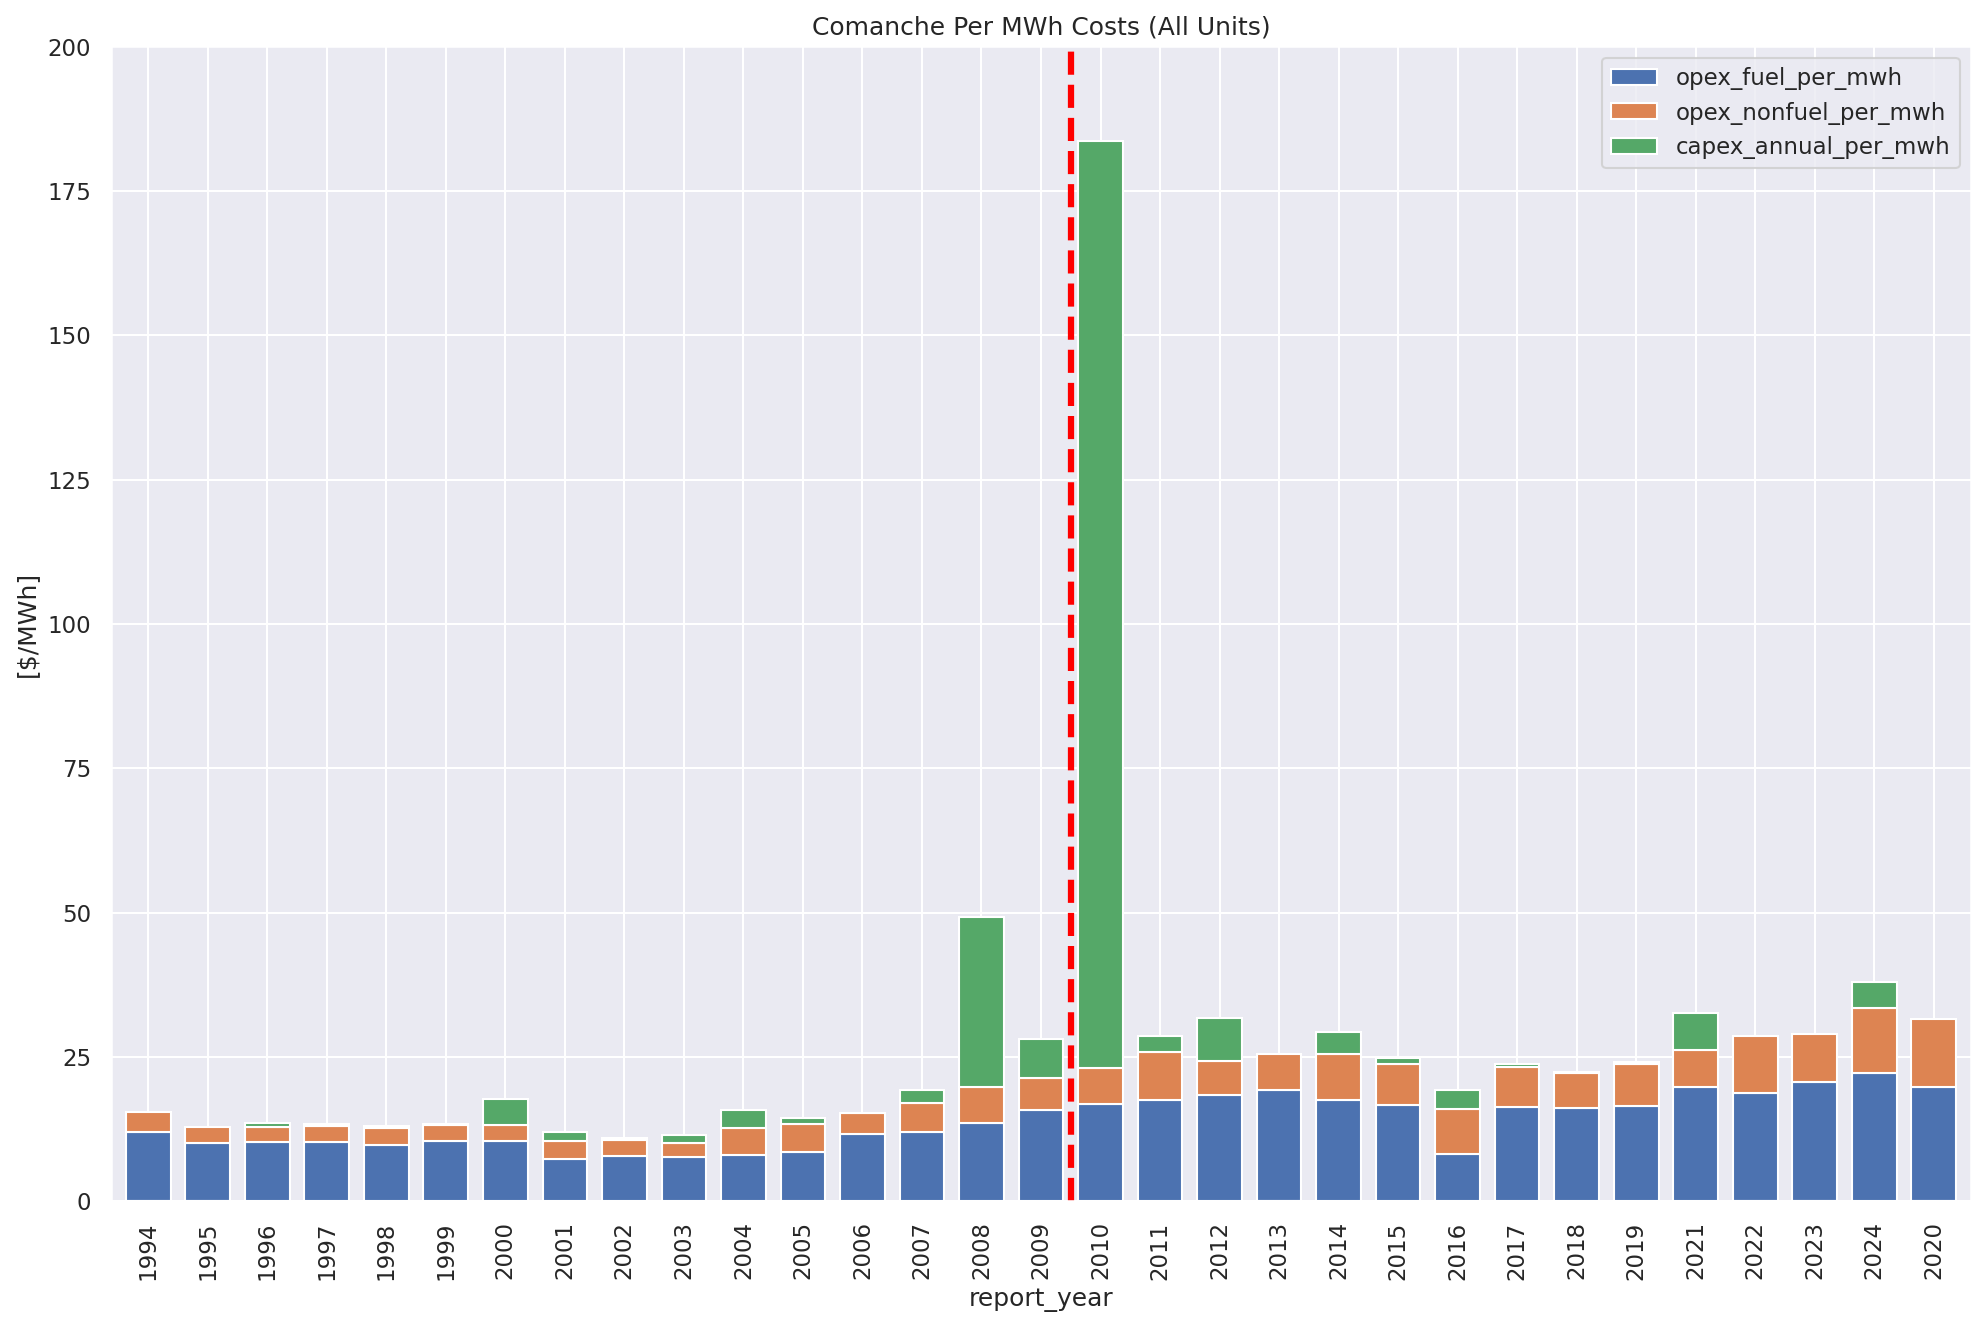

In [7]:
axes = comanche_ferc1.set_index("report_year")[[
    "opex_fuel_per_mwh",
    "opex_nonfuel_per_mwh",
    "capex_annual_per_mwh",
]].plot(
    kind="bar",
    stacked=True,
    width=0.75,
)
axes.axvline(x=15.5, color="red", linestyle="--", lw=3)
axes.set_ylabel("[$/MWh]")
axes.set_title("Comanche Per MWh Costs (All Units)")
axes.set_ylim(0, 200);

- At the same time, both fuel and non-fuel O&M costs per MWh increased significantly.
- Fuel prices are largely out of the utility's control and are a pure variable cost.
- The fuel costs in 2016 are anomalously low. Is this real, or a reporting error? EIA provides much more detailed fuel cost reporting (see below).
- Non-fuel O&M costs are a mix of fixed and variable costs. When fixed costs are spread out over a smaller number of MWh, the cost per MWh goes up.
- The capital additions plotted above really fall into 2 separate categories.
- There's a continuous background flow of money into the plant that's required to keep everything running -- some of which is categorized as O&M, and some of which gets categorized as capital investment and potentially added to the rate-base on which the utility earns a return.
- Prior to 2008 we can see an ongoing capital investment rate of sometehing like one USD per MWh of generation.
- In 2008 and 2010, capital additions are dramatically larger.
- In 2008 this was due to emissions controls that were added to the older Units 1 & 2.
- Then in 2010 the spike results from the more than 1 billion dollars of investmnet in Comanche 3 finally hitting the books.
- These large infrequent capital additions are meant to be paid off over multiple decades, and so aren't easily compared to the fuel and non-fuel O&M costs.
- However, the ongoing background trickle of capital additions is more like an ongoing maintenance cost, and are relatively comparable to the other O&M costs shown.


# Pre-calculated EIA Generator Statistics
* We have pre-calculated a number of useful generator statistics based on the EIA 860 and 923 data in the [Monthly Generators Table](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html#out-eia-monthly-generators)
* At first glance you might think these would be easy to calculate, but because of the different reporting requirements that apply to different sizes and types of power plants, that's unfortunately not true.
* These statistics are available both on a monthly and yearly basis.

In [8]:
%%time
comanche_mcoe = (
    read_parquet("out_eia__monthly_generators")
    .query("plant_id_eia==470")
    .sort_values(["report_date", "plant_id_eia", "generator_id"])
)
display(comanche_mcoe.info())
display(comanche_mcoe.sample(10))

<timed exec>:3: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.


<class 'pandas.core.frame.DataFrame'>
Index: 764 entries, 275265 to 275451
Columns: 110 entries, plant_id_eia to zip_code
dtypes: bool[pyarrow](27), date32[day][pyarrow](11), dictionary<values=string, indices=int32, ordered=0>[pyarrow](3), float[pyarrow](24), int32[pyarrow](8), string[pyarrow](37)
memory usage: 370.4 KB


None

plant_id_eia generator_id report_date  unit_id_pudl  plant_id_pudl  \
275180           470            3  2017-12-01             3            126   
275150           470            3  2015-06-01             3            126   
274993           470            2  2017-06-01             2            126   
275048           470            2  2022-01-01             2            126   
275409           470            2  2004-12-01          <NA>            126   
274933           470            2  2012-06-01             2            126   
275289           470            1  2003-01-01          <NA>            126   
274956           470            2  2014-05-01             2            126   
275023           470            2  2019-12-01             2            126   
275421           470            2  2005-12-01          <NA>            126   

       plant_name_eia  utility_id_eia  utility_id_pudl  \
275180       Comanche           15466              272   
275150       Comanche           15466              272   
274993       Comanche           15466              272   
275048       Comanche           15466              272   
275409       Comanche           15466              272   
274933       Comanche           15466              272   
275289       Comanche           15466              272   
274956       Comanche           15466              272   
275023       Comanche           15466              272   
275421       Comanche           15466              272   

                     utility_name_eia   technology_description  \
275180  Public Service Co of Colorado  Conventional Steam Coal   
275150  Public Service Co of Colorado  Conventional Steam Coal   
274993  Public Service Co of Colorado  Conventional Steam Coal   
275048  Public Service Co of Colorado  Conventional Steam Coal   
275409  Public Service Co of Colorado  Conventional Steam Coal   
274933  Public Service Co of Colorado  Conventional Steam Coal   
275289  Public Service Co of Colorado  Conventional Steam Coal   
274956  Public Service Co of Colorado  Conventional Steam Coal   
275023  Public Service Co of Colorado  Conventional Steam Coal   
275421  Public Service Co of Colorado  Conventional Steam Coal   

       energy_source_code_1 prime_mover_code generator_operating_date  \
275180                  SUB               ST               2010-07-01   
275150                  SUB               ST               2010-07-01   
274993                  SUB               ST               1975-06-01   
275048                  SUB               ST               1975-06-01   
275409                  SUB               ST               1975-06-01   
274933                  SUB               ST               1975-06-01   
275289                  BIT               ST               1973-06-01   
274956                  SUB               ST               1975-06-01   
275023                  SUB               ST               1975-06-01   
275421                  SUB               ST               1975-06-01   

       generator_retirement_date operational_status  capacity_mw  \
275180                      <NA>           existing   856.799988   
275150                      <NA>           existing   856.799988   
274993                      <NA>           existing        396.0   
275048                      <NA>           existing        396.0   
275409                      <NA>           existing        396.0   
274933                      <NA>           existing        396.0   
275289                      <NA>           existing        382.5   
274956                      <NA>           existing        396.0   
275023                      <NA>           existing        396.0   
275421                      <NA>           existing        396.0   

       fuel_type_code_pudl planned_generator_retirement_date  capacity_factor  \
275180                coal                              <NA>         0.806753   
275150                coal                              <NA>        

CPU times: user 12.8 s, sys: 4.89 s, total: 17.7 s
Wall time: 6.26 s


## Monthly Net Generation

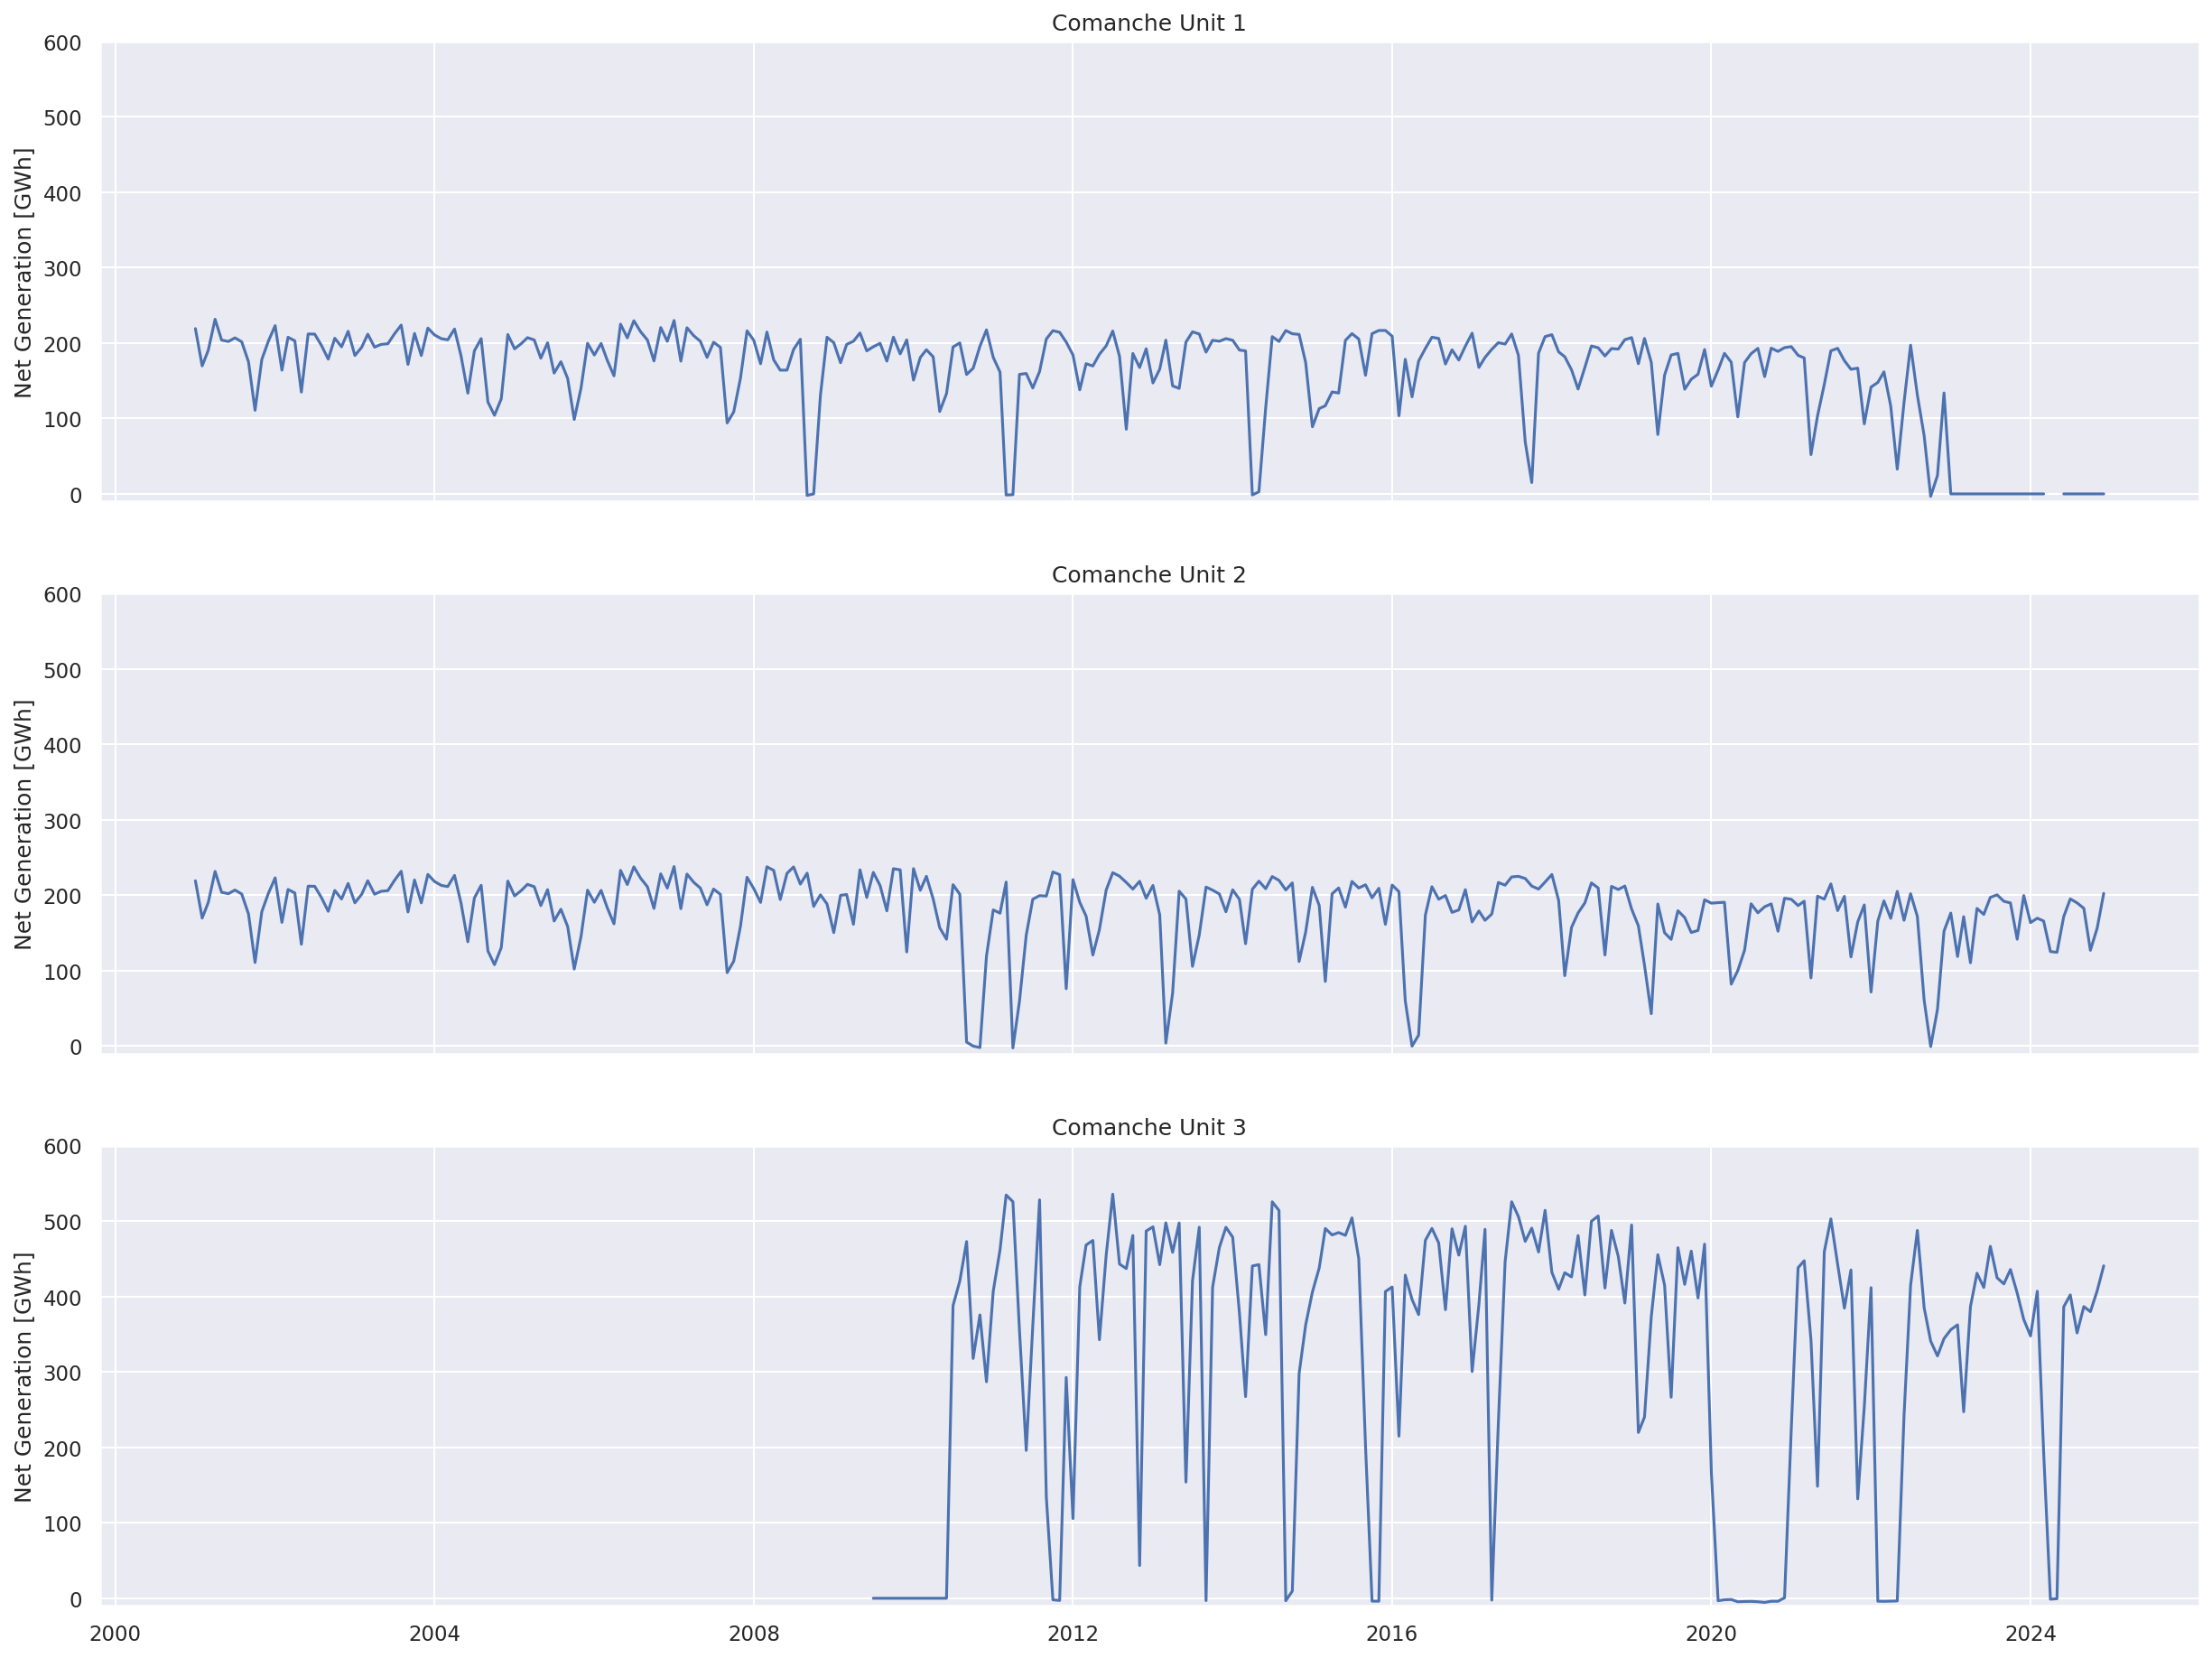

In [9]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].plot(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "net_generation_mwh"] / 1000.0,
    )
    axs[n].set_ylim(-10, 600)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Net Generation [GWh]")
plt.show();

## Monthly Fuel Costs per MWh

Fuel costs are reported for each fuel type of a plant. We allocate costs to the generator level based on net generation. To do this, we assume that each generator has the same fuel mix.

- Overall coal prices have been pretty stable.
- Unit 1 appears to have slightly higher fuel costs per MWh
- Spikes in per-MWh fuel costs are due to the fact that monthly fuel costs are based on fuel deliveries, which may still take place even if the plant is not operating.
- Note that the anomolously low fuel costs for 2016 that were present in the FERC Form 1 data above do not appear in the EIA data.

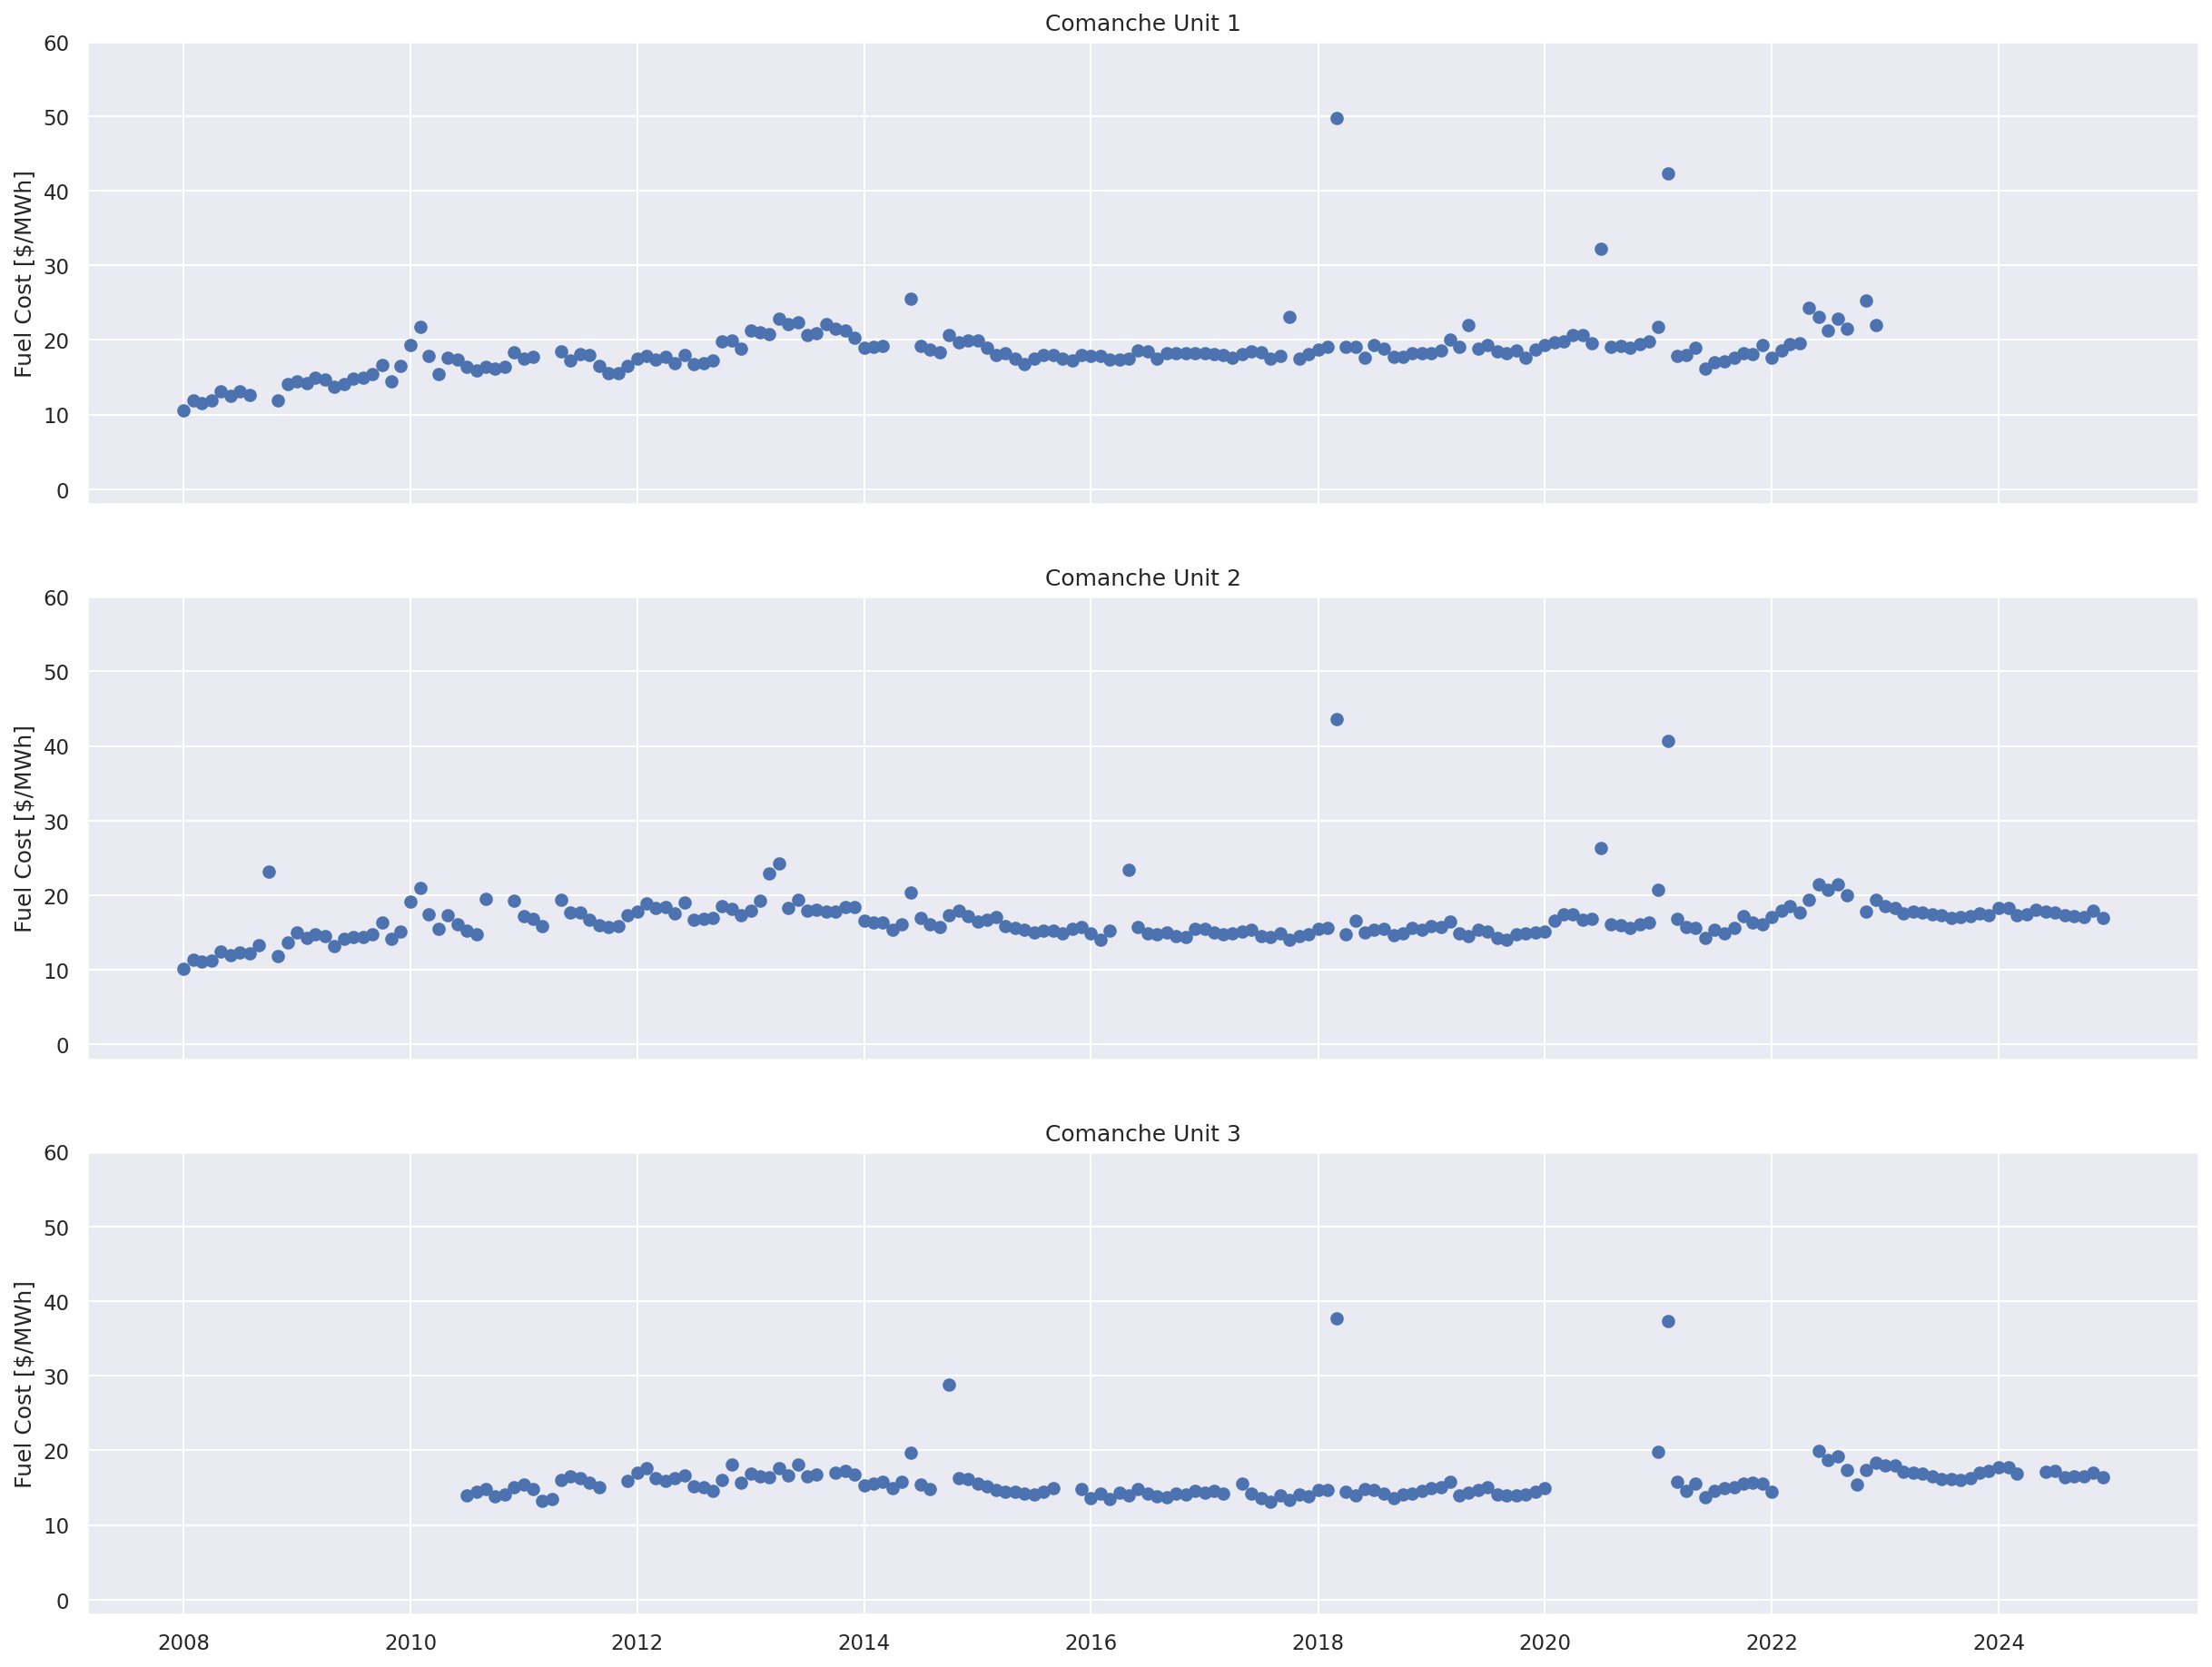

In [10]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].scatter(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "fuel_cost_per_mwh"],
    )
    axs[n].set_ylim(-2, 60)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Fuel Cost [$/MWh]")
plt.show();

## Monthly Average Heat Rates

These are calculated at the unit level using unit-level net generation and fuel consumption.

- The higher estimated heat rate for Unit 1 is likely the cause of higher fuel cost estimates above.

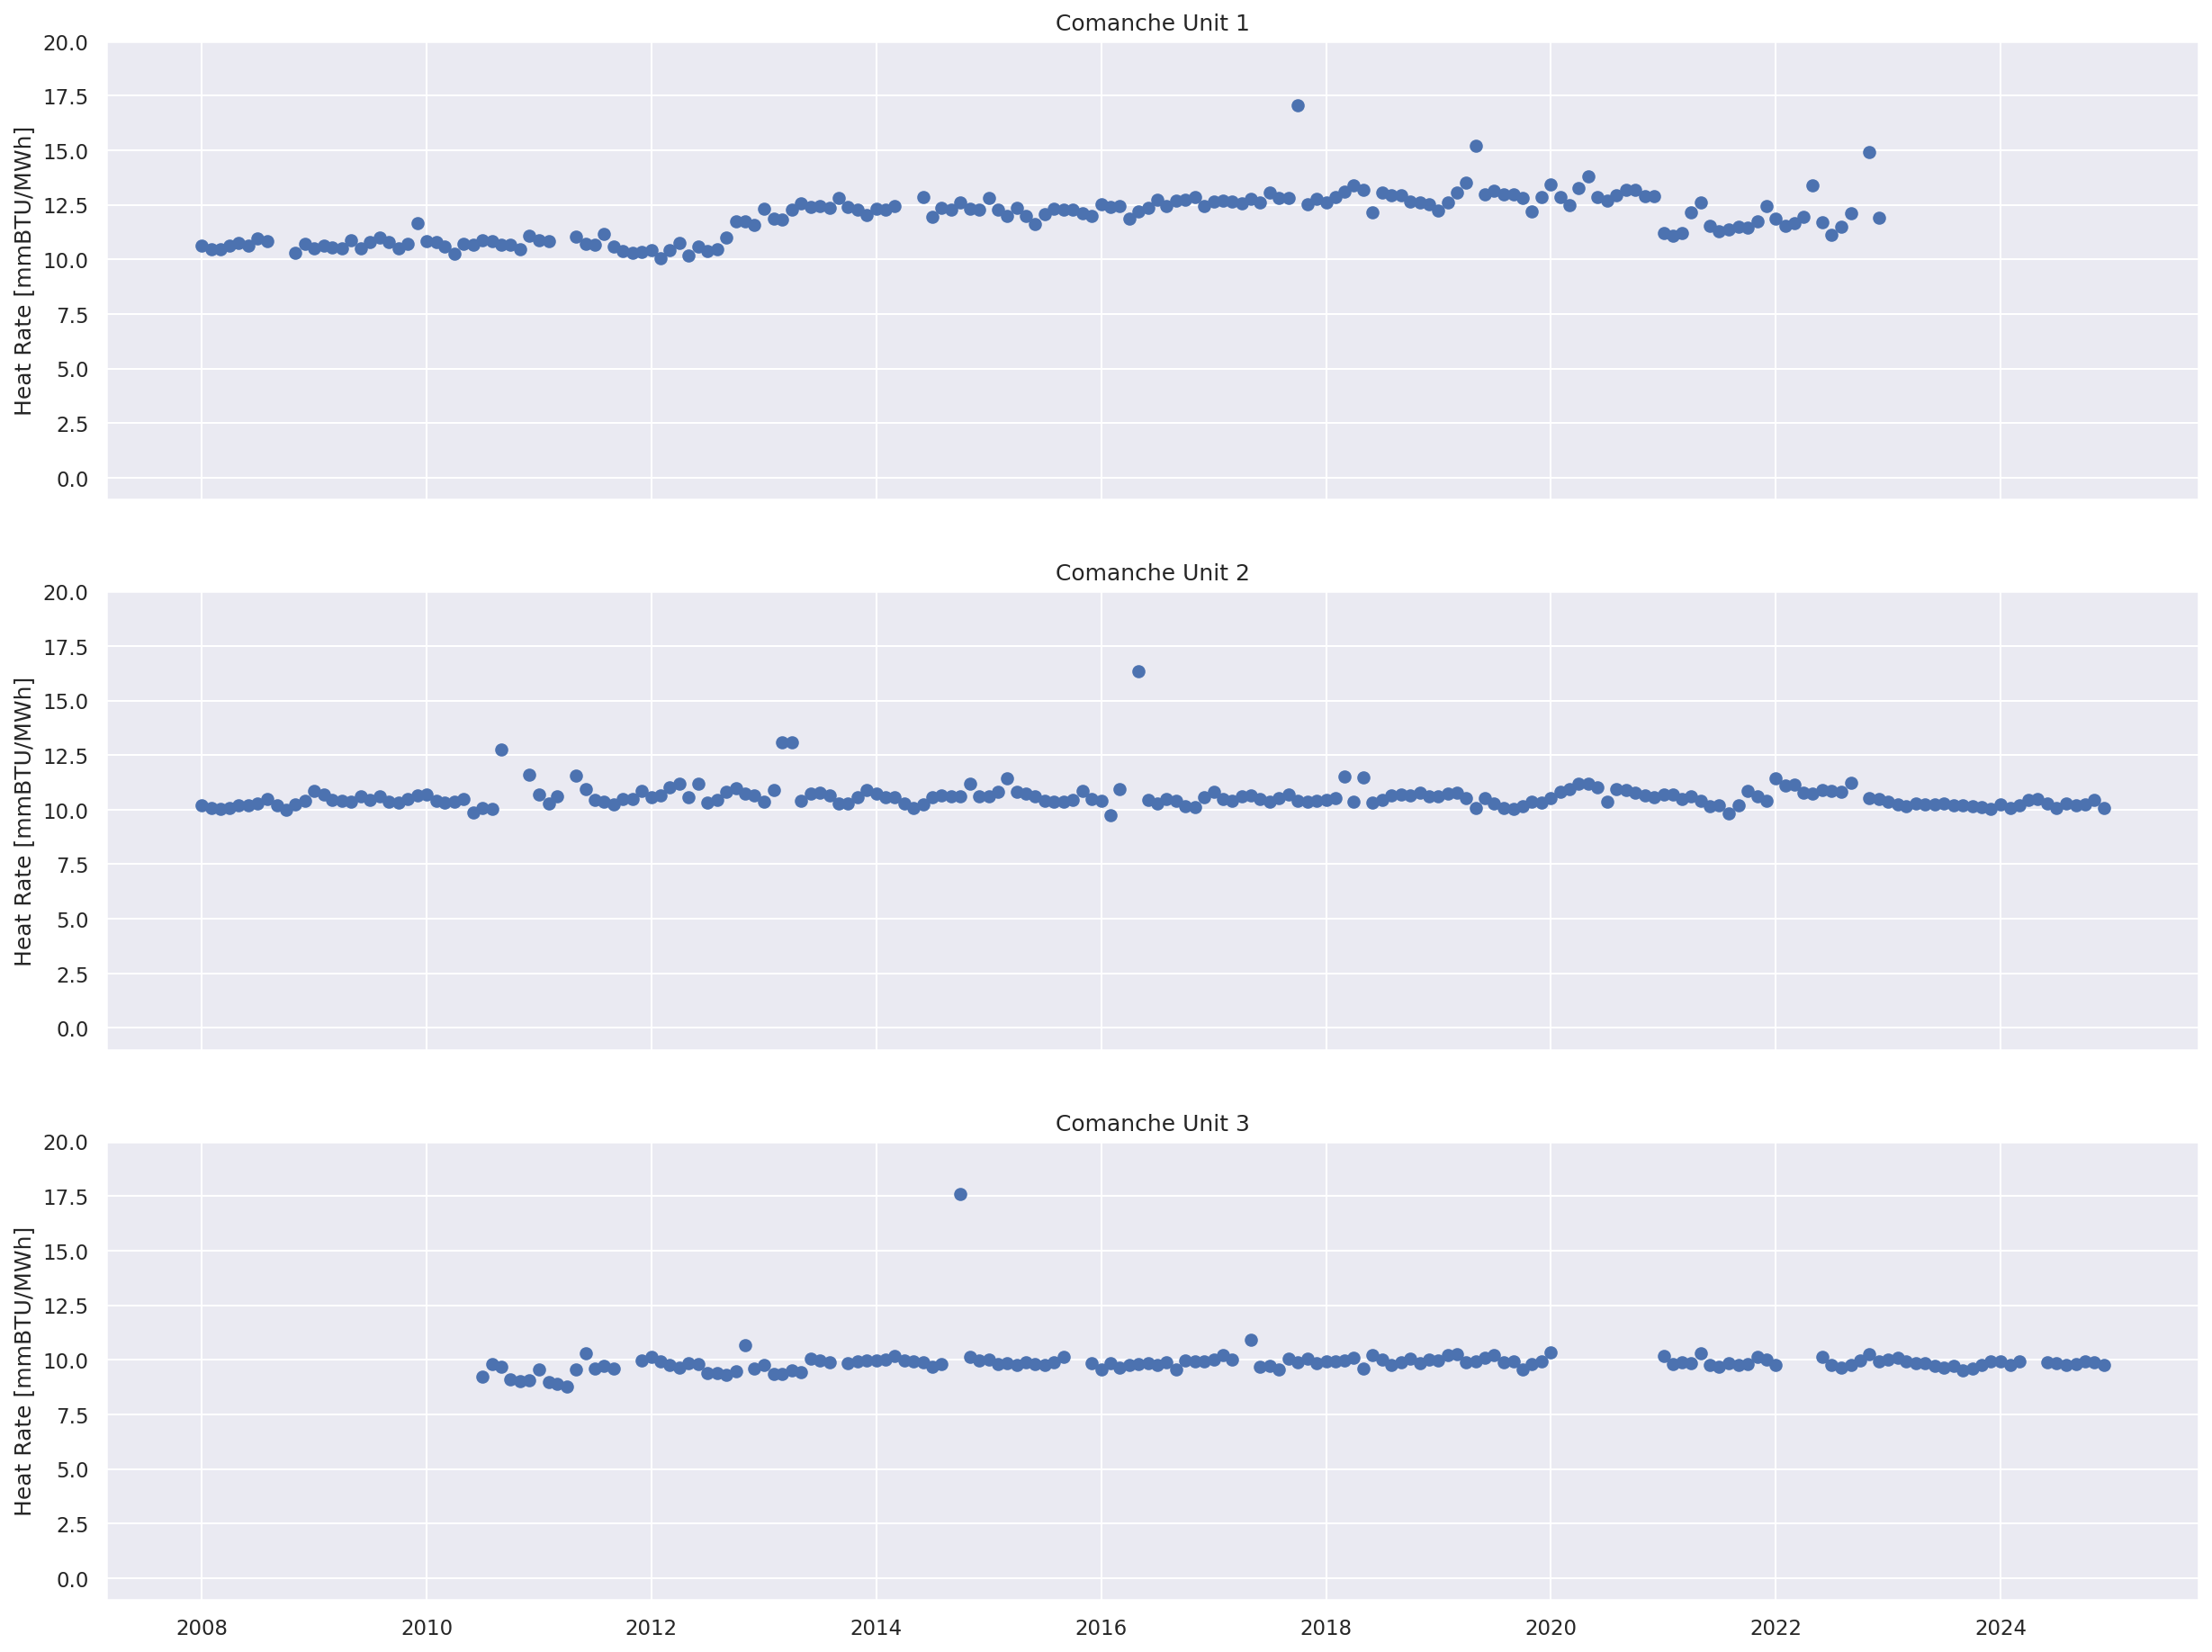

In [11]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].scatter(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "unit_heat_rate_mmbtu_per_mwh"],
    )
    axs[n].set_ylim(-1, 20)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Heat Rate [mmBTU/MWh]")
plt.show();

## Monthly Capacity Factor

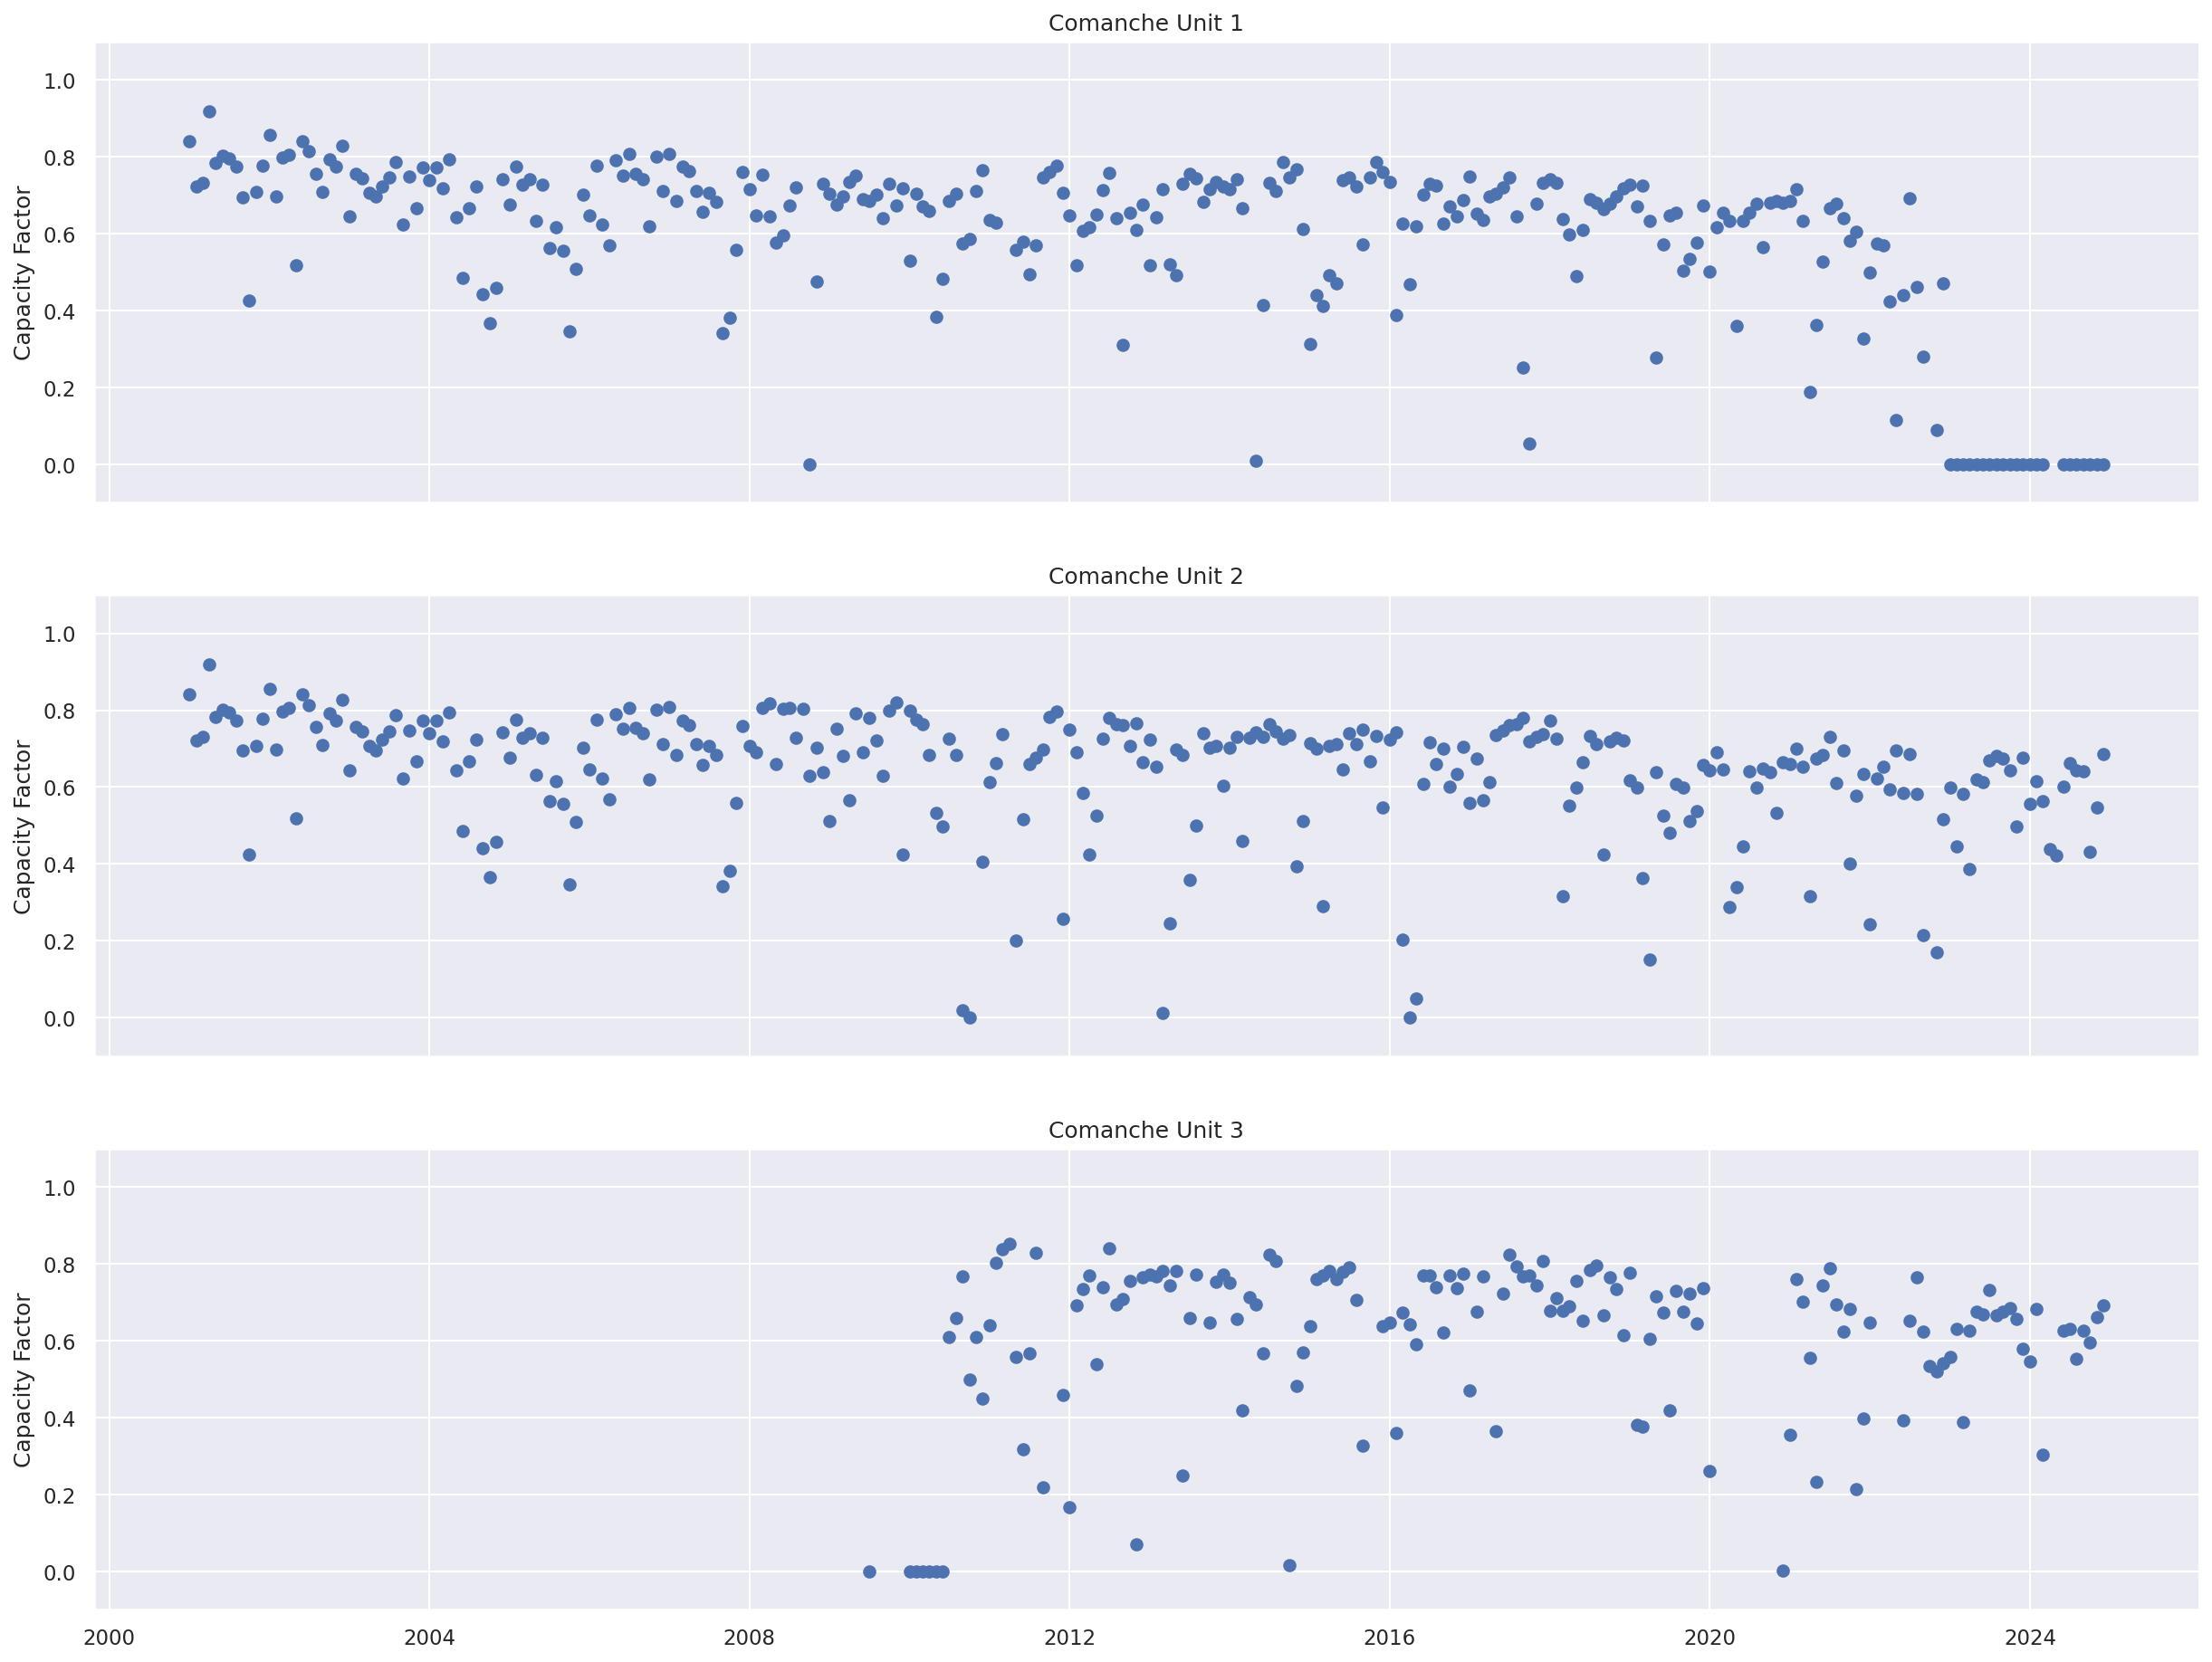

In [12]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].scatter(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "capacity_factor"],
    )
    axs[n].set_ylim(-0.1, 1.1)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Capacity Factor")
plt.show();

Some observations:
* Note the downtime period in 2020 for Comanche 3.

In [13]:
comanche_mcoe[comanche_mcoe.generator_id=="3"]

plant_id_eia generator_id report_date  unit_id_pudl  plant_id_pudl  \
275447           470            3  2005-01-01          <NA>            126   
275448           470            3  2006-01-01          <NA>            126   
275449           470            3  2007-01-01          <NA>            126   
275450           470            3  2008-01-01          <NA>            126   
275084           470            3  2009-07-01             3            126   
...              ...          ...         ...           ...            ...   
275261           470            3  2024-09-01             3            126   
275262           470            3  2024-10-01             3            126   
275263           470            3  2024-11-01             3            126   
275264           470            3  2024-12-01             3            126   
275451           470            3  2025-01-01          <NA>            126   

       plant_name_eia  utility_id_eia  utility_id_pudl  \
275447       Comanche           15466              272   
275448       Comanche           15466              272   
275449       Comanche           15466              272   
275450       Comanche           15466              272   
275084       Comanche           15466              272   
...               ...             ...              ...   
275261       Comanche           15466              272   
275262       Comanche           15466              272   
275263       Comanche           15466              272   
275264       Comanche           15466              272   
275451       Comanche           15466              272   

                     utility_name_eia   technology_description  \
275447  Public Service Co of Colorado  Conventional Steam Coal   
275448  Public Service Co of Colorado  Conventional Steam Coal   
275449  Public Service Co of Colorado  Conventional Steam Coal   
275450  Public Service Co of Colorado  Conventional Steam Coal   
275084  Public Service Co of Colorado  Conventional Steam Coal   
...                               ...                      ...   
275261  Public Service Co of Colorado  Conventional Steam Coal   
275262  Public Service Co of Colorado  Conventional Steam Coal   
275263  Public Service Co of Colorado  Conventional Steam Coal   
275264  Public Service Co of Colorado  Conventional Steam Coal   
275451  Public Service Co of Colorado  Conventional Steam Coal   

       energy_source_code_1 prime_mover_code generator_operating_date  \
275447                  SUB               ST               2010-07-01   
275448                  SUB               ST               2010-07-01   
275449                  SUB               ST               2010-07-01   
275450                  SUB               ST               2010-07-01   
275084                  SUB               ST               2010-07-01   
...                     ...              ...                      ...   
275261                  SUB               ST               2010-07-01   
275262                  SUB               ST               2010-07-01   
275263                  SUB               ST               2010-07-01   
275264                  SUB               ST               2010-07-01   
275451                  SUB               ST               2010-07-01   

       generator_retirement_date operational_status  capacity_mw  \
275447                      <NA>           proposed        820.0   
275448                      <NA>           proposed        820.0   
275449                      <NA>           proposed        820.0   
275450                      <NA>           proposed   856.799988   
275084                      <NA>           proposed   856.799988   
...                          ...                ...          ...   
275261                      <NA>           existing   856.799988   
275262                      <NA>           existing   856.799988   
275263                      <NA>           existing   856.799988   
275264                  

# Read Hourly Generation & Emissions Data from Apache Parquet
* The full hourly emissions time series for thousands of US power plants covering 1995-present contains almost a billion records.
* The data is stored in a single [Apache Parquet file](https://parquet.apache.org/) with row-groups defined by year and state.
* This compressed columnar format enables very efficient queries with appropriate tooling.
* If we read the entire dataset into memory all at once, it will exceed the available memory.
* Instead we'll use [DuckDB](https://duckdb.org/docs/data/parquet/overview.html) to query the large table, reading only the data that we're interested in.

In [14]:
import duckdb

unit_ids = ["1", "2", "3"]
cems_cols = [
    "operating_datetime_utc",
    "plant_id_eia",
    "plant_id_epa",
    "emissions_unit_id_epa",
    "operating_time_hours",
    "gross_load_mw",
    "heat_content_mmbtu",
    "co2_mass_tons",
]

sql = f"""
SELECT {", ".join(cems_cols)}
FROM '{PARQUET_PATH}/core_epacems__hourly_emissions.parquet'
WHERE (state = 'CO') AND (plant_id_eia = 470)
"""

with duckdb.connect() as conn:
    comanche_cems = conn.execute(sql).df()

comanche_cems = comanche_cems.assign(
    gross_generation_mwh=lambda x: x.operating_time_hours * x.gross_load_mw,
    heat_rate_mmbtu_per_mwh=lambda x: x.heat_content_mmbtu / x.gross_generation_mwh,
    gross_co2_intensity=lambda x: x.co2_mass_tons / x.gross_generation_mwh
)
comanche_cems.info()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609168 entries, 0 to 609167
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   operating_datetime_utc   609168 non-null  datetime64[us]
 1   plant_id_eia             609168 non-null  int32         
 2   plant_id_epa             609168 non-null  int32         
 3   emissions_unit_id_epa    609168 non-null  object        
 4   operating_time_hours     608884 non-null  float32       
 5   gross_load_mw            517986 non-null  float32       
 6   heat_content_mmbtu       517986 non-null  float32       
 7   co2_mass_tons            517986 non-null  float32       
 8   gross_generation_mwh     517986 non-null  float32       
 9   heat_rate_mmbtu_per_mwh  517974 non-null  float32       
 10  gross_co2_intensity      517904 non-null  float32       
dtypes: datetime64[us](1), float32(7), int32(2), object(1)
memory usage: 30.2+ MB


## Power Output
- The scatter plots below contain more than half a million points.
- They show the operational patterns of the 3 Comanche units at hourly resolution.
- Clear upper and lower bounds on plant operating output are visible, with Unit 3 typically operating between 510 and 800 MW.
- Note that even though Units 1 & 2 are ~50 years old (they came online in 1973 and 1975, respectively) they seem to be up and running more frequently than the brand-new Unit 3.
- In particular, Unit 3 spent most of 2020 offline, and since experienced multiple months-long periods of downtime.
- Because Unit 3 is more than 50% of the overall plant's generating capacity, these outages have had a huge impact in overall capacity factor, as we saw above in the FERC Form 1 capacity factor data.

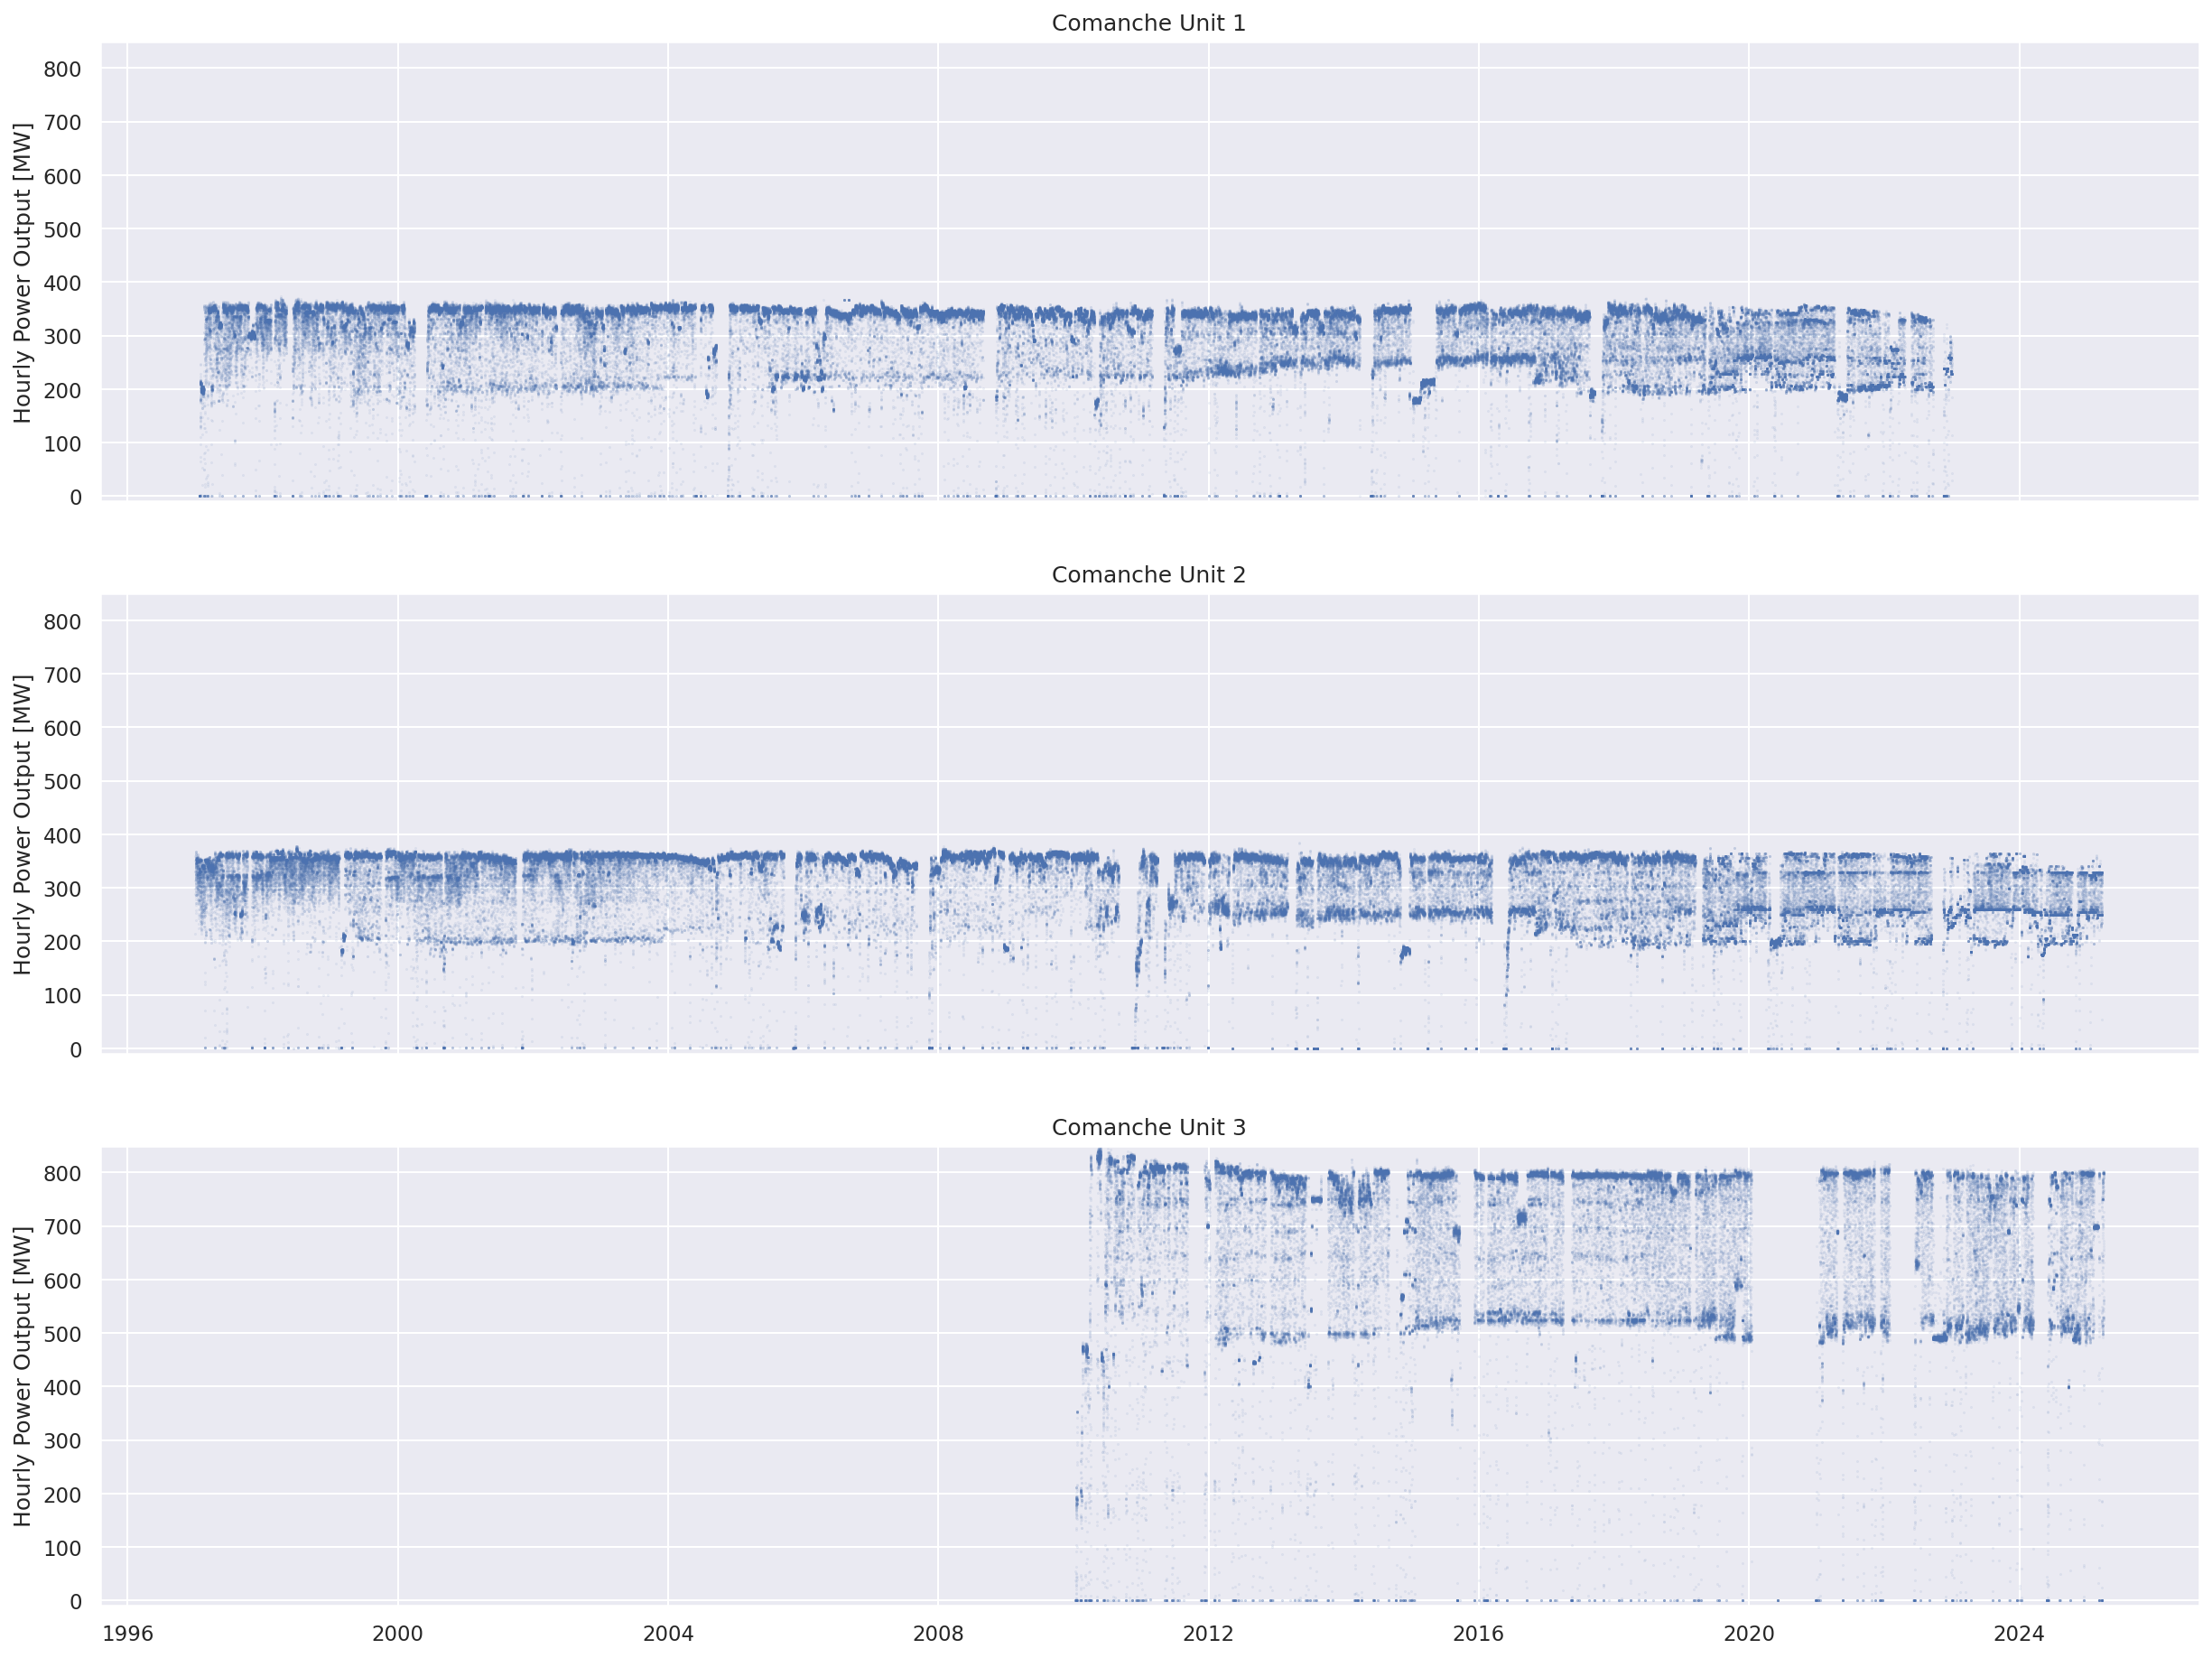

In [15]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "gross_generation_mwh"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-10, 850)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Hourly Power Output [MW]")
plt.show();

## Fuel Consumption

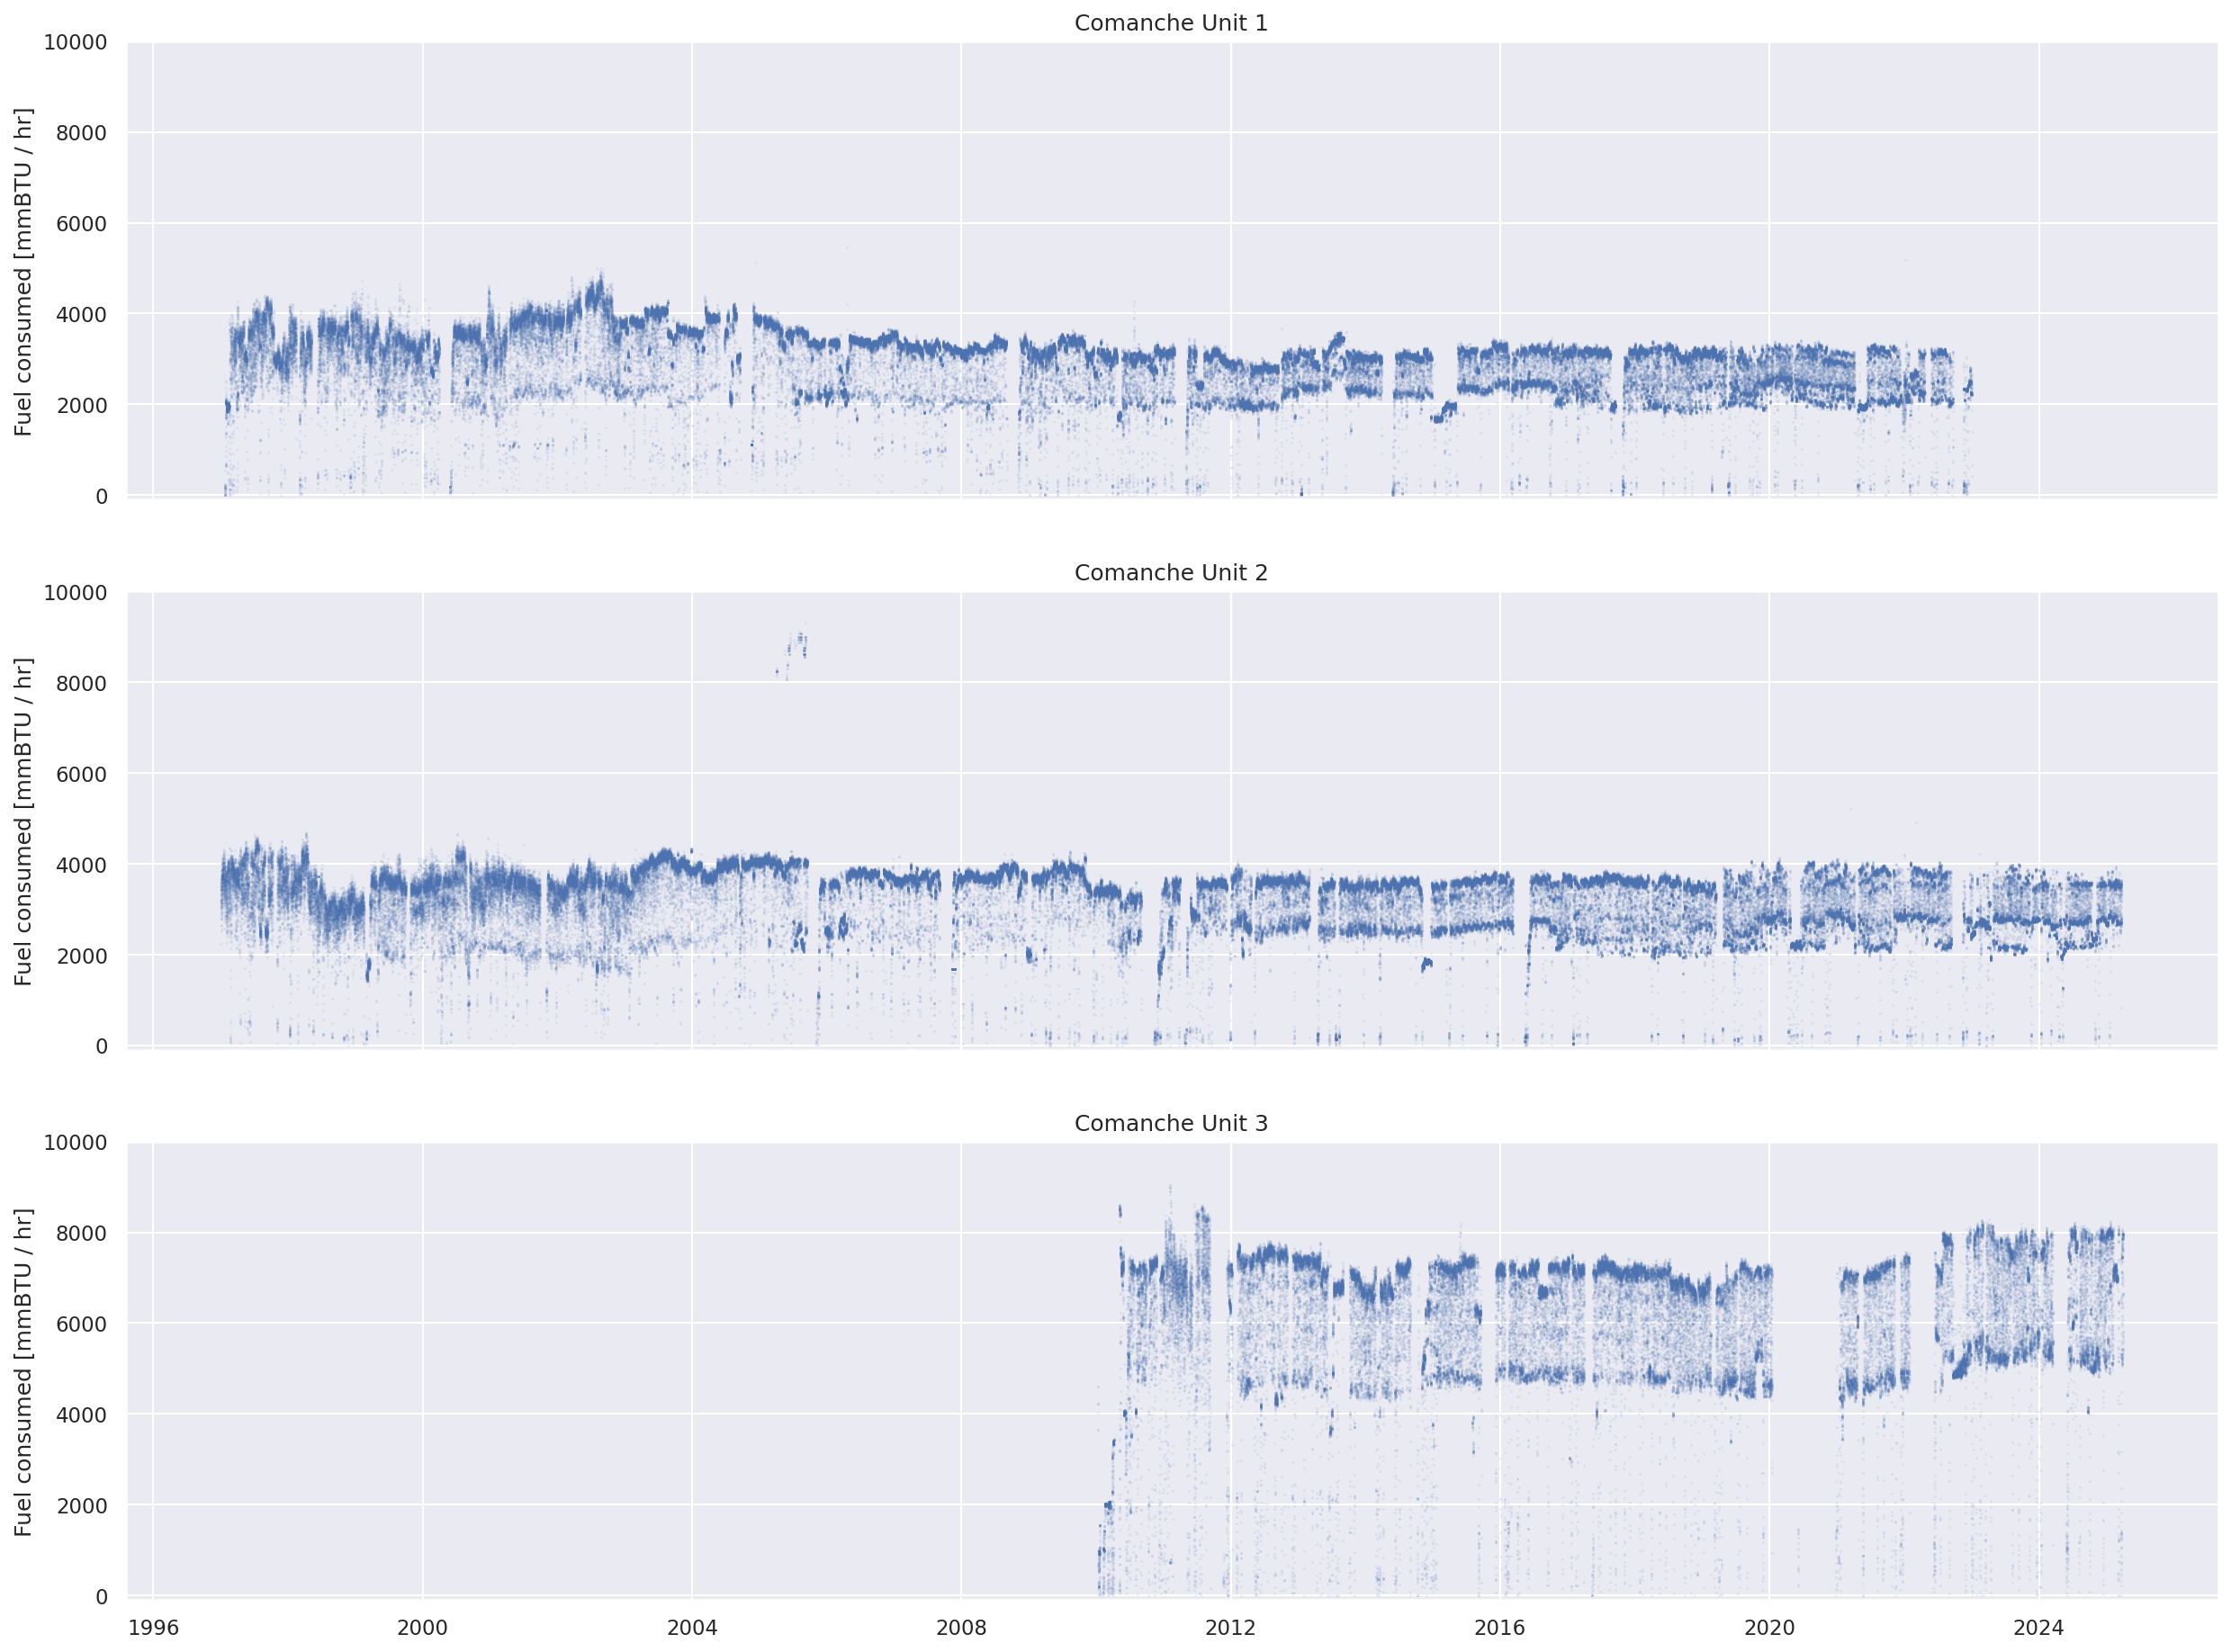

In [16]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "heat_content_mmbtu"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-100,10_000)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Fuel consumed [mmBTU / hr]")
plt.show();

## Heat Rates

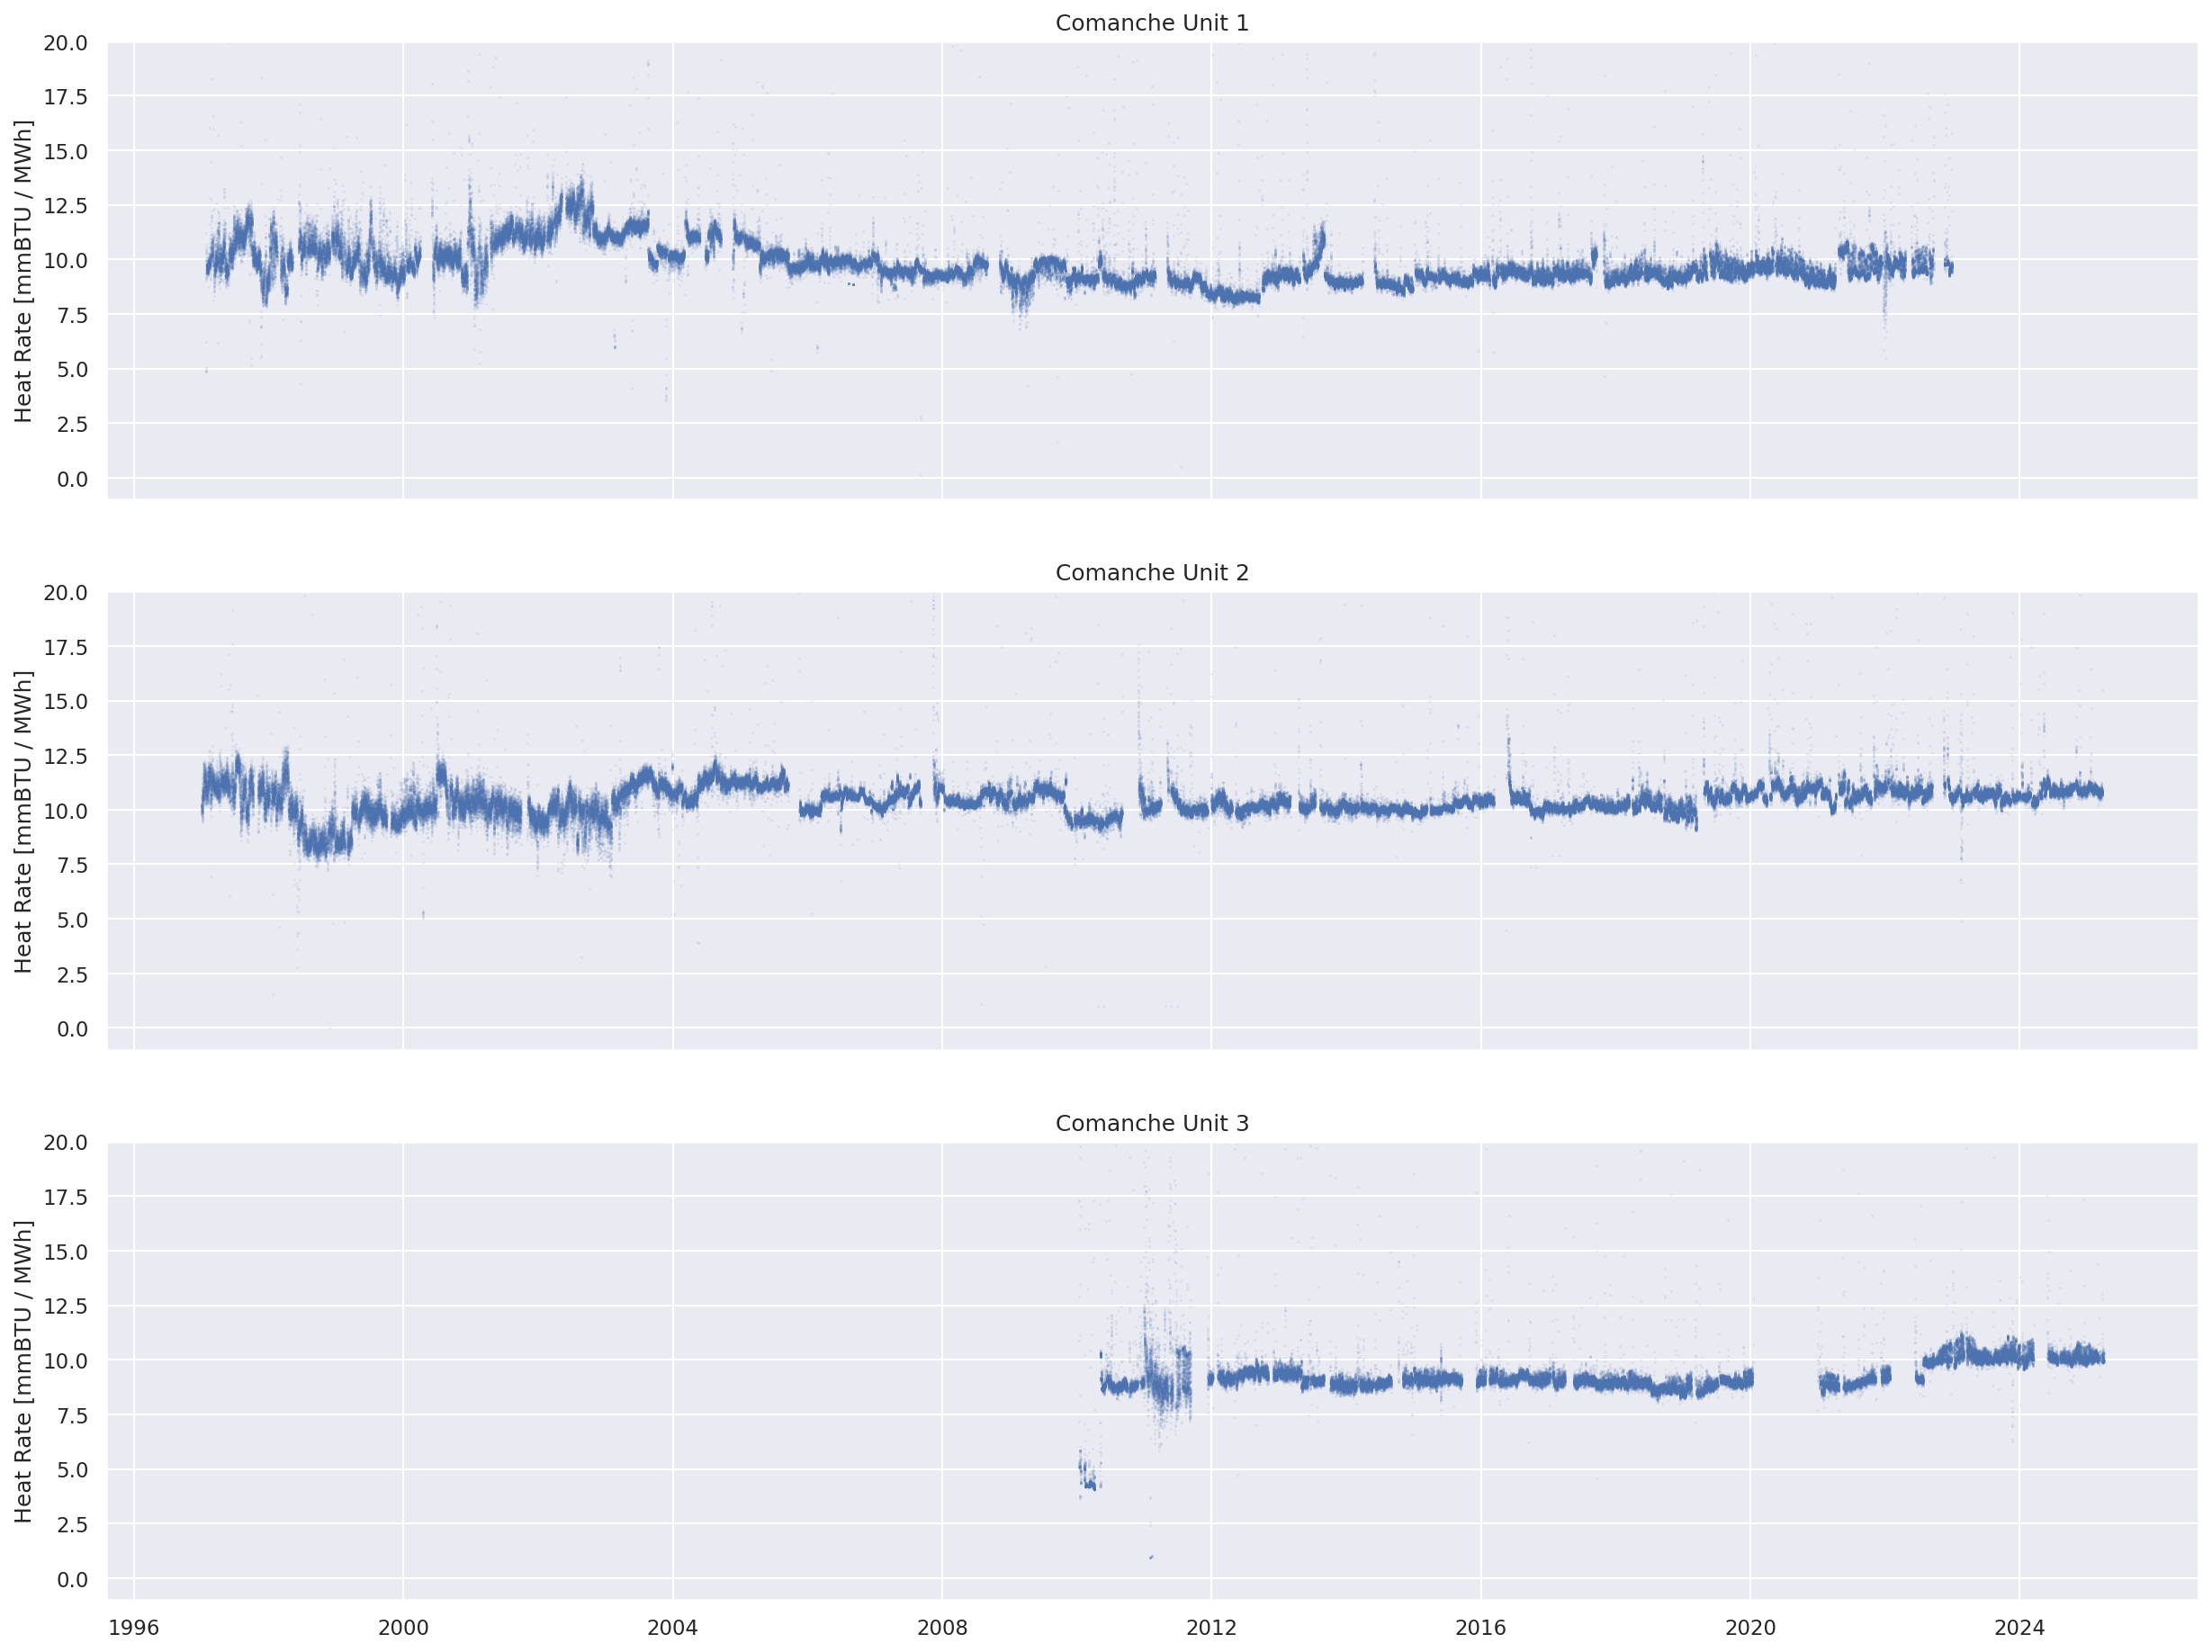

In [17]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "heat_rate_mmbtu_per_mwh"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-1,20)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Heat Rate [mmBTU / MWh]")
plt.show();

## Emissions Intensity

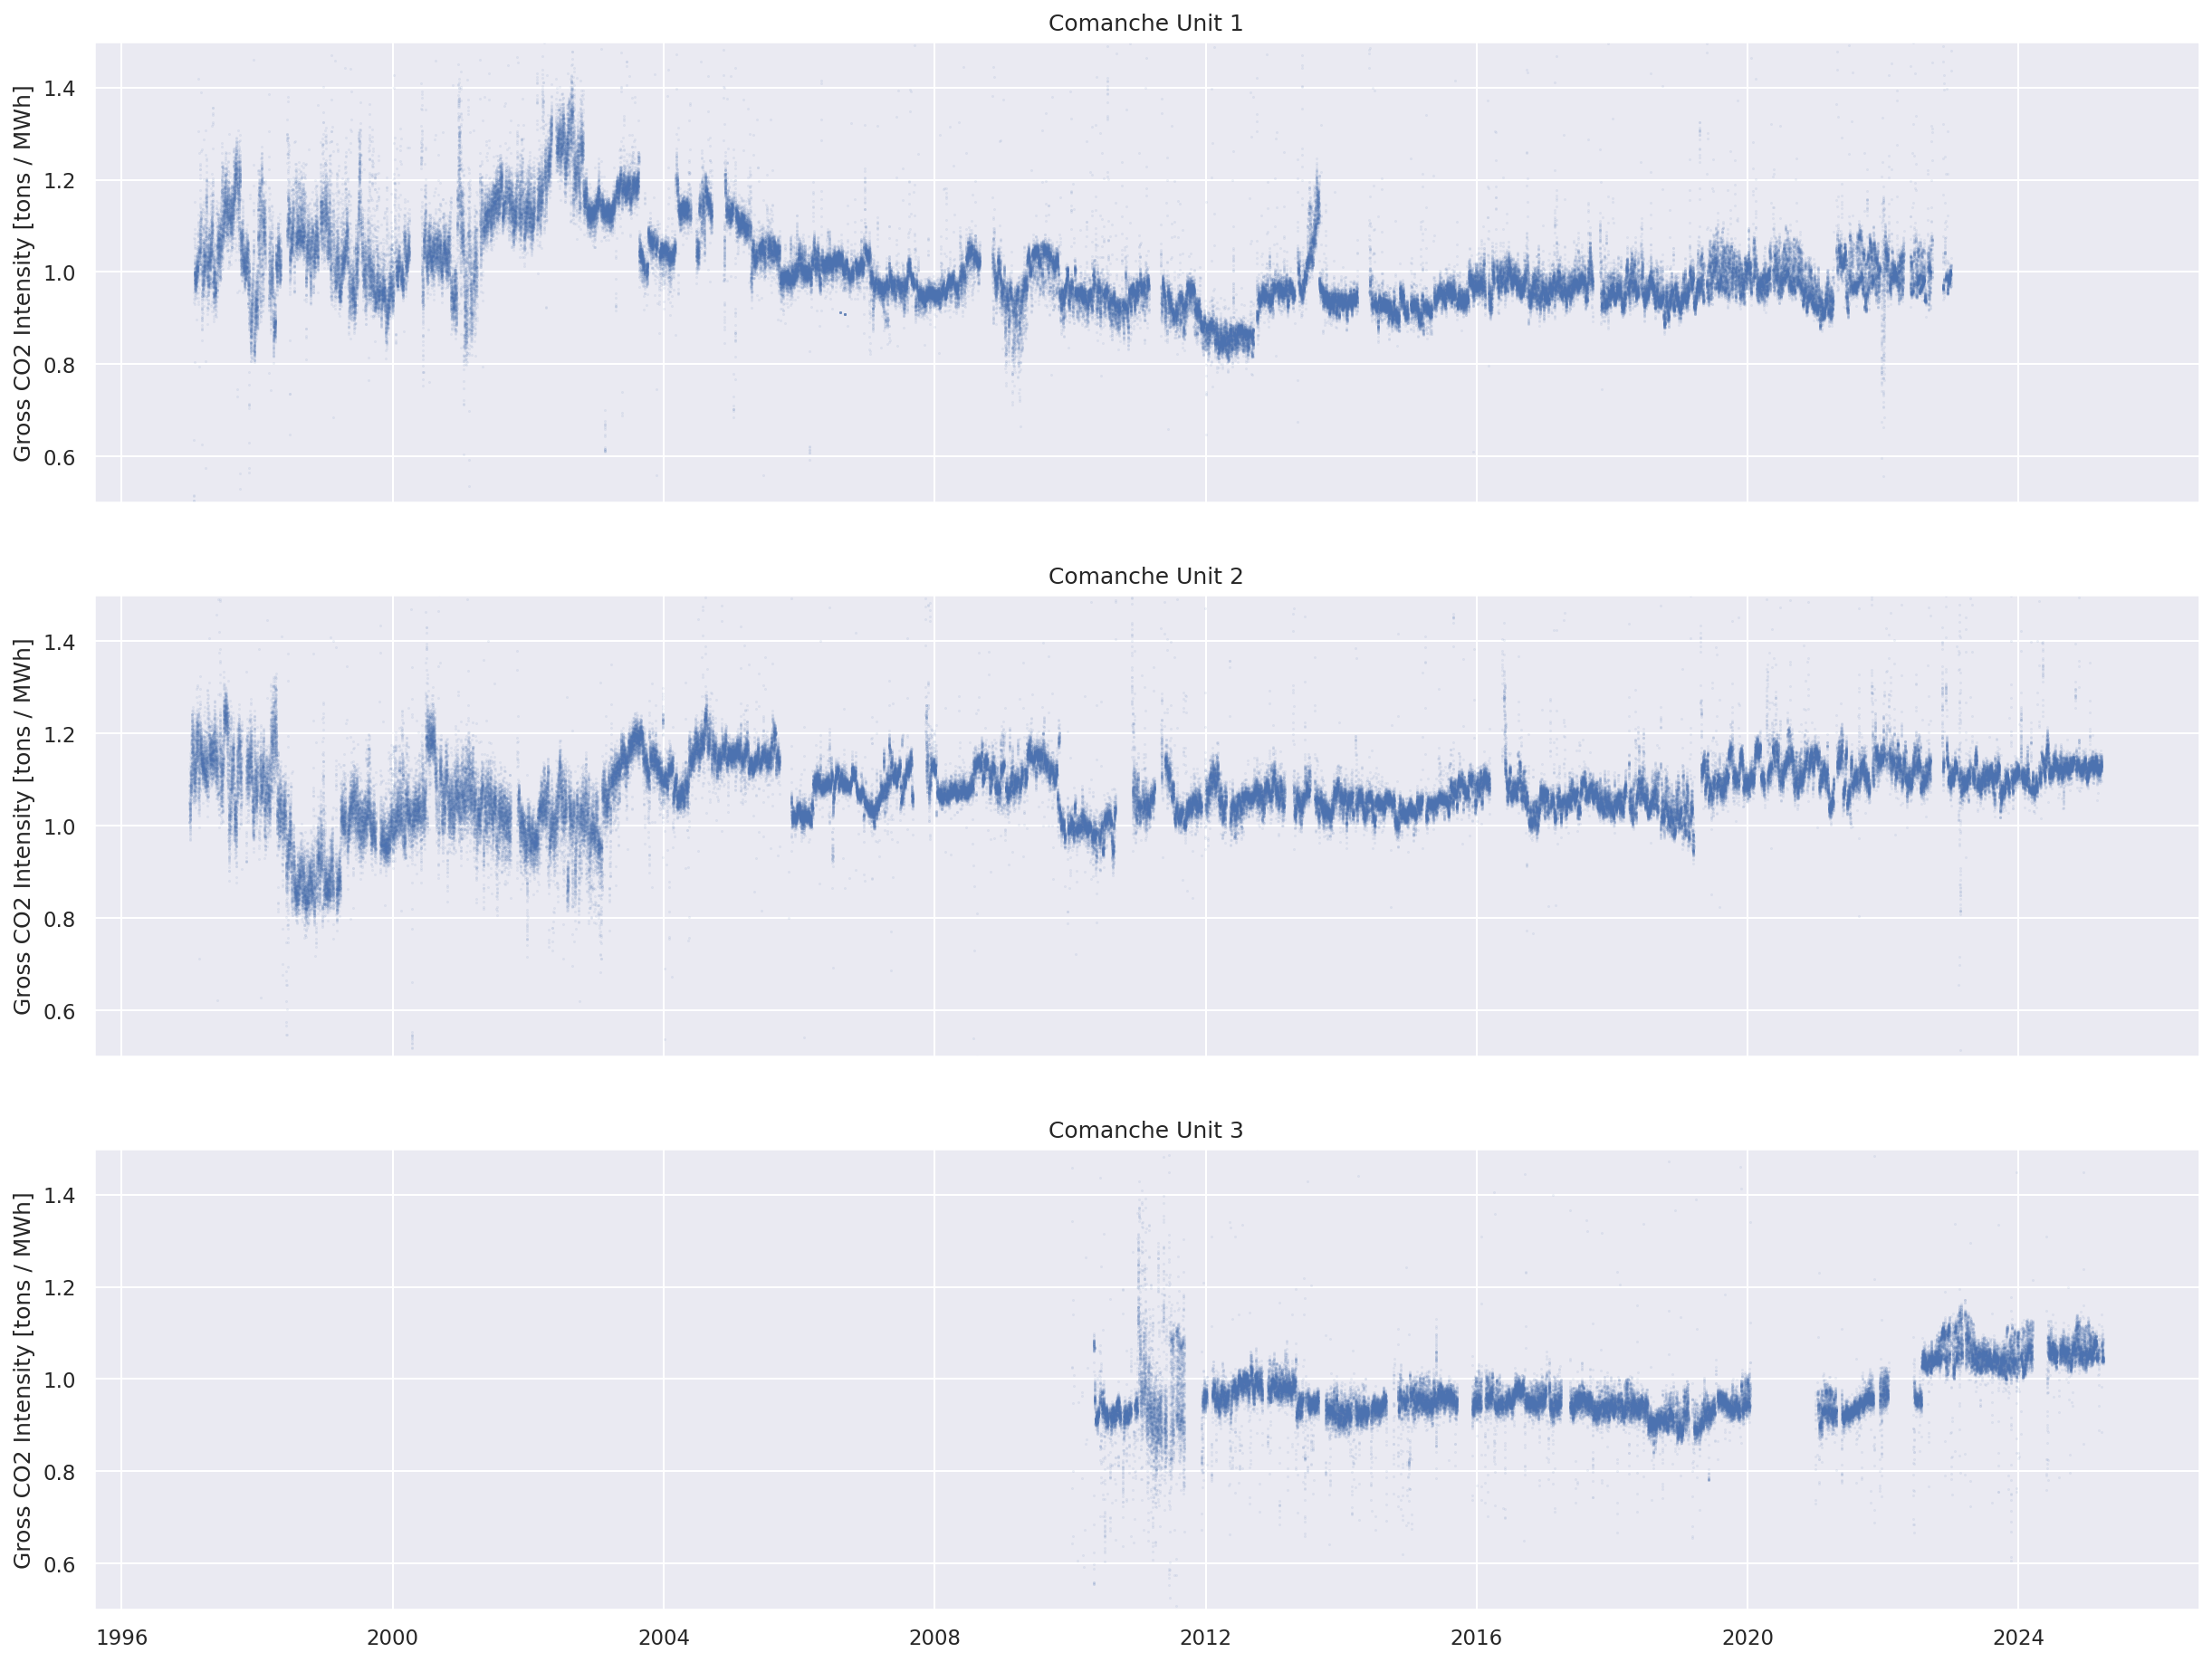

In [18]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "gross_co2_intensity"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(0.5,1.5)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Gross CO2 Intensity [tons / MWh]")
plt.show();